# Project Fletcher
Kenny Leung - kenleung11@gmail.com 
<br><br>
Part 1/1 - Sentiment Analysis on iPhone X based on YouTube comments
<br><br>
This notebook documents the process of obtaining data, exploratory data analysis, text processing, unsupervised learning, and preparing data for visualization.

In [ ]:
import os
import html

import google.oauth2.credentials

import google_auth_oauthlib.flow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline
from collections import Counter

from sklearn.externals import joblib
from pymongo import MongoClient
import string
import nltk
from nltk.corpus import stopwords, words
from nltk import PorterStemmer, clean_html
from textblob import TextBlob
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from gensim import corpora, models, similarities, matutils
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)



https://developers.google.com/youtube/v3/docs/commentThreads/list <br>
https://developers.google.com/youtube/v3/docs/search/list

# Define YouTube API functions

In [37]:
# -*- coding: utf-8 -*-
# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret.
CLIENT_SECRETS_FILE = "client_secret.json"

# This OAuth 2.0 access scope allows for full read/write access to the
# authenticated user's account and requires requests to use an SSL connection.
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

def get_authenticated_service():
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
    credentials = flow.run_console()
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

# def print_response(response):
#     print(response)

# Build a resource based on a list of properties given as key-value pairs.
# Leave properties with empty values out of the inserted resource.
def build_resource(properties):
    resource = {}
    for p in properties:
    # Given a key like "snippet.title", split into "snippet" and "title", where
    # "snippet" will be an object and "title" will be a property in that object.
        prop_array = p.split('.')
        ref = resource
    for pa in range(0, len(prop_array)):
        is_array = False
        key = prop_array[pa]

      # For properties that have array values, convert a name like
      # "snippet.tags[]" to snippet.tags, and set a flag to handle
      # the value as an array.
        if key[-2:] == '[]':
            key = key[0:len(key)-2:]
            is_array = True

        if pa == (len(prop_array) - 1):
        # Leave properties without values out of inserted resource.
            if properties[p]:
                if is_array:
                    ref[key] = properties[p].split(',')
                else:
                    ref[key] = properties[p]
        elif key not in ref:
        # For example, the property is "snippet.title", but the resource does
        # not yet have a "snippet" object. Create the snippet object here.
        # Setting "ref = ref[key]" means that in the next time through the
        # "for pa in range ..." loop, we will be setting a property in the
        # resource's "snippet" object.
            ref[key] = {}
            ref = ref[key]
        else:
        # For example, the property is "snippet.description", and the resource
        # already has a "snippet" object.
            ref = ref[key]
    return resource

# Remove keyword arguments that are not set
def remove_empty_kwargs(**kwargs):
    good_kwargs = {}
    if kwargs is not None:
        for key, value in kwargs.items():
            if value:
                good_kwargs[key] = value
    return good_kwargs

def comment_threads_list_by_video_id(client, **kwargs):
  # See full sample for function
    kwargs = remove_empty_kwargs(**kwargs)

    response = client.commentThreads().list(**kwargs).execute()

    return response

def search_list_by_keyword(client, **kwargs):
  # See full sample for function
    kwargs = remove_empty_kwargs(**kwargs)

    response = client.search().list(**kwargs).execute()

    return response

# Store in MongoDB

In [38]:
client = MongoClient()
youtube_comments = client.fletcher_db.youtube_comments
youtube_videos = client.fletcher_db.youtube_videos

In [41]:
%timeit
youtube_comments.drop()
youtube_videos.drop()

if __name__ == '__main__':
  # When running locally, disable OAuthlib's HTTPs verification. When
  # running in production *do not* leave this option enabled.
    os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
    client = get_authenticated_service()
  
    search = search_list_by_keyword(client,part='snippet',maxResults=10,q='iphone X',type='video',order='viewCount',
                                   relevanceLanguage='en')
    
    youtube_videos.insert_one(search)
    
    videoids = [item['id']['videoId'] for item in search['items']] 
    
    for video in videoids:
        try:
            comments = comment_threads_list_by_video_id(client,part='snippet,replies',videoId=video)

            youtube_comments.insert_one(comments)

            while 'nextPageToken' in comments.keys():
                comments = comment_threads_list_by_video_id(client,part='snippet,replies',
                                                            videoId=video,
                                                            pageToken=comments['nextPageToken'])
                youtube_comments.insert_one(comments)
            
        except HttpError:
            pass

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=557363991231-0klptnl1ccgmq22pns39vv3f29eevo4c.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=ZlKGEVZUuSWGQR0JQDWh2RnKykTmSX&prompt=consent&access_type=offline
Enter the authorization code: 4/vvaL_0JW3a17ubiJlr0GUmXxclAkCLamrWcs_Un1nNE


In [42]:
youtube_comments

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'fletcher_db'), 'youtube_comments')

In [43]:
youtube_videos

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'fletcher_db'), 'youtube_videos')

# Create videos Pandas DataFrame from MongoDB

In [44]:
published = []
titles = []
videos = []

for video in youtube_videos.find_one()['items']:
    published.append(video['snippet']['publishedAt'])
    titles.append(video['snippet']['title'])
    videos.append(video['id']['videoId'])

In [45]:
videos_df = pd.DataFrame({'Published at':published,'Titles': titles,'VideoId': videos})

In [56]:
#joblib.dump(videos_df,'videos_top50_mongodb.pkl')
joblib.dump(videos_df,'videos_top10_en.pkl')

['videos_top10_en.pkl']

In [2]:
videos_df = joblib.load('videos_top10_en.pkl')

In [3]:
videos_df

,Published at,Titles,VideoId
0,2017-09-12T18:59:36.000Z,iPhone X — Introducing iPhone X — Apple,K4wEI5zhHB0
1,2017-09-12T18:59:49.000Z,Meet iPhone X — Apple,mW6hFttt_KE
2,2017-07-24T03:55:02.000Z,iPhone 7 — The Rock x Siri Dominate the Day — ...,ufBLI6bB9sg
3,2017-09-13T01:53:52.000Z,iPhone X vs iPhone 8/8 Plus - Which Should You...,BT4ig34Olo4
4,2017-07-06T03:47:05.000Z,iPhone X & 8 Clone Unboxing!,RLqxvsY9gto
5,2017-09-13T04:22:51.000Z,iPhone X Impressions & Hands On!,_HTXMhKWqnA
6,2017-09-12T22:03:04.000Z,Первый обзор iPhone X на русском,wufo7_54G3I
7,2017-09-12T23:30:12.000Z,iPhone X Face ID Unlock Fail,unIkqhB2nA0
8,2017-07-08T18:28:05.000Z,I've Got The iPhone X Prototype!!!,4WHMgBs_C3s
9,2017-09-12T19:58:47.000Z,Apple iPhone X first look,WYYvHb03Eog


# Create comments Pandas DataFrame from MongoDB

In [ ]:
times = []
authors = []
texts = []
likes = []
replies = []

for pages in youtube_comments.find():
    for comments in pages['items']:
        times.append(comments['snippet']['topLevelComment']['snippet']['publishedAt'])
        authors.append(comments['snippet']['topLevelComment']['snippet']['authorDisplayName'])
        texts.append(comments['snippet']['topLevelComment']['snippet']['textDisplay'])
        likes.append(comments['snippet']['topLevelComment']['snippet']['likeCount'])
        replies.append(comments['snippet']['totalReplyCount'])

In [404]:
comments_df = pd.DataFrame({'Published at':times,
                            'Author': authors,
                            'Comments': texts,
                            'Likes': likes, 
                            'Replies': replies},columns=('Published at','Author','Comments','Likes','Replies'))

In [5]:
#not english
len(comments_df[32614:37238])

4624

In [406]:
comments_df.drop(comments_df.index[range(32614,37238)], inplace=True)
comments_df.reset_index(drop=True, inplace=True)

In [409]:
#joblib.dump(comments_df,'comments_top50_mongodb.pkl')
joblib.dump(comments_df,'comments_top10_en.pkl')

['comments_top10_en.pkl']

In [410]:
comments_df = joblib.load('comments_top10_en.pkl')

In [11]:
len(comments_df)

61877

In [271]:
#comments_df[comments_df['Comments'].str.contains('wireless charger')]

# Text Pre-processing

In [12]:
df = joblib.load('comments_top10_en.pkl')

In [13]:
#remove unicode such as &#39
def unescape(x):
    return html.unescape(x)

def text_process(comment):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Stems all words
    4. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in comment if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    nostopwords = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

    ps = PorterStemmer()
    stems = [ps.stem(word) for word in nostopwords]
    return ' '.join(stems)

In [415]:
%time
df['Comments'] = df['Comments'].apply(unescape)
df['Comments'] = df['Comments'].apply(text_process)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [416]:
joblib.dump(df,'cleaned_text_df.pkl')

['cleaned_text_df.pkl']

# TFIDF

In [225]:
df = joblib.load('cleaned_text_df.pkl')

In [226]:
corpus = df['Comments']

In [227]:
tf = TfidfVectorizer(min_df=40,ngram_range=(1,3))
tfidf_vecs =  tf.fit_transform(corpus)
tfidf_matrix = tfidf_vecs.toarray()

In [228]:
tfidf_matrix.shape

(61877, 2477)

In [229]:
#tf.get_feature_names()

In [230]:
df_tfidf = pd.DataFrame(tfidf_matrix,columns=tf.get_feature_names())

In [37]:
#pd.Series(df_tfidf.columns[df_tfidf.columns.str.contains('39')])

In [232]:
#df_tfidf

In [39]:
# Naive Bayes or Logistic Regression Before PCA only for Supervised Learning

# Principal Component Analysis

In [12]:
X = df_tfidf
X_centered = X - np.mean(X, axis=0)

In [14]:
X.shape

(61877, 2477)

In [434]:
n_components = 2400
step = 100
perc_variance_explained = []

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_centered)
    
for n in range(100,n_components+step,step):
    perc_variance_explained.append(sum(pca.explained_variance_ratio_[:n])*100)
    print(str(round(sum(pca.explained_variance_ratio_[:n])*100,2)),
      '% variance explained by the first {} components'.format(n))

31.58 % variance explained by the first 100 components
44.34 % variance explained by the first 200 components
53.14 % variance explained by the first 300 components
59.82 % variance explained by the first 400 components
65.1 % variance explained by the first 500 components
69.56 % variance explained by the first 600 components
73.35 % variance explained by the first 700 components
76.62 % variance explained by the first 800 components
79.48 % variance explained by the first 900 components
82.01 % variance explained by the first 1000 components
84.28 % variance explained by the first 1100 components
86.33 % variance explained by the first 1200 components
88.18 % variance explained by the first 1300 components
89.85 % variance explained by the first 1400 components
91.38 % variance explained by the first 1500 components
92.77 % variance explained by the first 1600 components
94.05 % variance explained by the first 1700 components
95.23 % variance explained by the first 1800 components
96

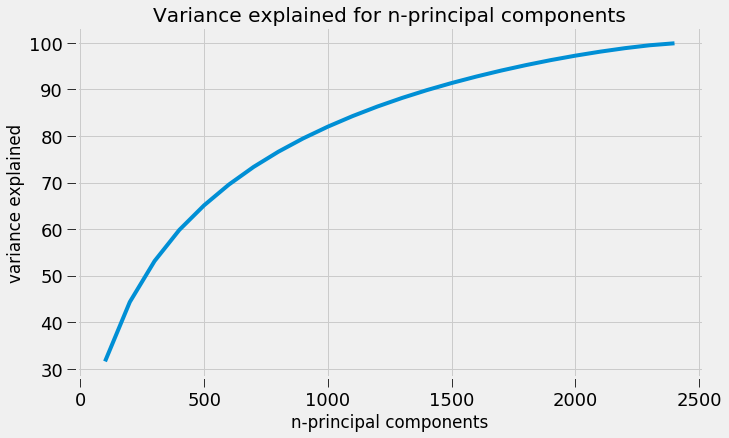

In [435]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

plt.plot(range(100,n_components+step,step), perc_variance_explained)

plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Variance explained for n-principal components')
plt.xlabel('n-principal components')
plt.ylabel('variance explained');

# LSI with GENSIM

In [40]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())

# Row indices
id2word = dict((v, k) for k, v in tf.vocabulary_.items())

id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

2017-11-04 14:46:16,438 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:16,537 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:16,619 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:16,739 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:16,857 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:16,976 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:17,072 : INFO : adding document #60000 to Dictionary(0 unique tokens: [])
2017-11-04 14:46:17,101 : INFO : built Dictionary(2477 unique tokens: ['iphon', 'user', 'long', 'time', 'first']...) from 61877 documents (total 155798 corpus positions)


In [41]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=300)

2017-11-04 14:46:18,346 : INFO : using serial LSI version on this node
2017-11-04 14:46:18,348 : INFO : updating model with new documents
2017-11-04 14:46:18,513 : INFO : preparing a new chunk of documents
2017-11-04 14:46:18,611 : INFO : using 100 extra samples and 2 power iterations
2017-11-04 14:46:18,612 : INFO : 1st phase: constructing (2477, 400) action matrix
2017-11-04 14:46:18,934 : INFO : orthonormalizing (2477, 400) action matrix
2017-11-04 14:46:19,252 : INFO : 2nd phase: running dense svd on (400, 20000) matrix
2017-11-04 14:46:19,857 : INFO : computing the final decomposition
2017-11-04 14:46:19,858 : INFO : keeping 300 factors (discarding 8.512% of energy spectrum)
2017-11-04 14:46:19,876 : INFO : processed documents up to #20000
2017-11-04 14:46:19,878 : INFO : topic #0(24.312): 0.921*"iphon" + 0.118*"plu" + 0.104*"get" + 0.096*"buy" + 0.093*"like" + 0.088*"iphon plu" + 0.070*"look" + 0.069*"br" + 0.058*"iphon iphon" + 0.058*"get iphon"
2017-11-04 14:46:19,879 : INFO : 

In [42]:
# Retrieve vectors for the original tfidf corpus in the LSI space
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
len(doc_vecs[0])

300

In [43]:
# Create an index transformer that calculates similarity based on our space
index = similarities.MatrixSimilarity(doc_vecs,num_features=len(id2word))

2017-11-04 14:46:31,183 : INFO : creating matrix with 61877 documents and 2477 features


In [44]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[0]]), key=lambda item: -item[1])

In [45]:
# Let's take a look at how we did
for sim_doc_id, sim_score in sims[0:10]: 
    print("Score: " + str(sim_score))
    print("Document: " + corpus[sim_doc_id])
    print('\n')

Score: 1.0
Document: iphon user long time first iphon 3G back 2008 right use iphon 5s believ still work year wast money gadget figur phone someth use stay connect friend famili Id never spend 12001300 get away 300400 devic Id rather spend 500 go pro hero 5 need captur action rug use better focal length spend money order upgrad len collect dslr


Score: 0.591712
Document: 2017 still use handi phone save money futur


Score: 0.566217
Document: money wast iphon X shouldv use iphon 8 add new stuff anyway android user 🙄😂


Score: 0.513126
Document: heed advic save money phone still work nice use


Score: 0.510573
Document: money iphon X


Score: 0.509565
Document: iphon rate hype wast money


Score: 0.507296
Document: iphon wast money


Score: 0.507296
Document: iphon X wast money


Score: 0.505417
Document: hot money bug iphon x


Score: 0.494178
Document: still use iphon 5s




In [46]:
joblib.dump(corpus,'corpus_gensim.pkl')

['corpus_gensim.pkl']

# LSI for Machine Learning

In [47]:
# Convert the gensim-style corpus vecs to a numpy array for sklearn manipulations
comments_lsi = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()
comments_lsi.shape

(61877, 300)

In [48]:
# Normalize vector space
row_norms = np.array([np.linalg.norm(x) for x in comments_lsi])
new_matrix = comments_lsi / row_norms[:, np.newaxis]

/Users/kennyleung/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
comments_norm_df = pd.DataFrame(new_matrix)

In [50]:
# Get list of NaN indices, and drop NaN rows
nan_index = comments_norm_df.index[np.isnan(comments_norm_df[0])].tolist()
comments_norm_df.dropna(axis=0, how='any',inplace=True)

In [51]:
len(nan_index)

2629

In [52]:
len(comments_norm_df)

59248

In [53]:
len(comments_norm_df)+len(nan_index)

61877

In [54]:
# comments_norm_df = comments_norm_df.reset_index(drop=True)

In [55]:
joblib.dump(comments_norm_df,'norm_df_gensim.pkl')

['norm_df_gensim.pkl']

# K-Means Clustering

In [443]:
comments_norm_df = joblib.load('norm_df_gensim.pkl')

In [444]:
comments_norm_df.shape

(59248, 300)

In [39]:
# Use elbow method to determine n_clusters for K-Means

inertias = []
for n in range(2,21):
    km = KMeans(n_clusters=n).fit(comments_norm_df)
    inertias.append(km.inertia_)
    print('Inertia score for {} clusters: '.format(n),km.inertia_)

Inertia score for 2 clusters:  56382.1090263
Inertia score for 3 clusters:  55613.5073561
Inertia score for 4 clusters:  55028.0670035
Inertia score for 5 clusters:  54481.8401911
Inertia score for 6 clusters:  53851.6491951
Inertia score for 7 clusters:  53451.5207332
Inertia score for 8 clusters:  52937.42196
Inertia score for 9 clusters:  52577.2483863
Inertia score for 10 clusters:  52133.5012553
Inertia score for 11 clusters:  51921.9907139
Inertia score for 12 clusters:  51544.9645157
Inertia score for 13 clusters:  51217.3856068
Inertia score for 14 clusters:  50793.4960627
Inertia score for 15 clusters:  50574.9127289
Inertia score for 16 clusters:  50376.545126
Inertia score for 17 clusters:  49906.621465
Inertia score for 18 clusters:  49789.3059959
Inertia score for 19 clusters:  49604.310725
Inertia score for 20 clusters:  49280.3452095


In [47]:
for n in range(21,31):
    km = KMeans(n_clusters=n).fit(comments_norm_df)
    inertias.append(km.inertia_)
    print('Inertia score for {} clusters: '.format(n),km.inertia_)

Inertia score for 21 clusters:  48915.9995272
Inertia score for 22 clusters:  48749.7663846
Inertia score for 23 clusters:  48401.2728056
Inertia score for 24 clusters:  48267.5892083
Inertia score for 25 clusters:  48132.3215724
Inertia score for 26 clusters:  47688.8437142
Inertia score for 27 clusters:  47632.8804505
Inertia score for 28 clusters:  47334.4553659
Inertia score for 29 clusters:  47243.3846781
Inertia score for 30 clusters:  46758.8230983


In [51]:
for n in range(31,41):
    km = KMeans(n_clusters=n).fit(comments_norm_df)
    inertias.append(km.inertia_)
    print('Inertia score for {} clusters: '.format(n),km.inertia_)

Inertia score for 31 clusters:  46602.9825922
Inertia score for 32 clusters:  46582.9334507
Inertia score for 33 clusters:  46502.2853619
Inertia score for 34 clusters:  46236.3279842
Inertia score for 35 clusters:  46037.5174139
Inertia score for 36 clusters:  45976.040416
Inertia score for 37 clusters:  45739.1165587
Inertia score for 38 clusters:  45535.4096417
Inertia score for 39 clusters:  45286.6975229
Inertia score for 40 clusters:  45367.5754586


In [53]:
for n in range(41,51):
    km = KMeans(n_clusters=n).fit(comments_norm_df)
    inertias.append(km.inertia_)
    print('Inertia score for {} clusters: '.format(n),km.inertia_)

Inertia score for 41 clusters:  45034.6927871
Inertia score for 42 clusters:  44769.6109297
Inertia score for 43 clusters:  44811.8663786
Inertia score for 44 clusters:  44660.902698
Inertia score for 45 clusters:  44457.7275552
Inertia score for 46 clusters:  44296.9571798
Inertia score for 47 clusters:  44166.0777814
Inertia score for 48 clusters:  44128.8492196
Inertia score for 49 clusters:  43995.6817694
Inertia score for 50 clusters:  43718.76914


In [133]:
for n in range(51,61):
    km = KMeans(n_clusters=n).fit(comments_norm_df)
    inertias.append(km.inertia_)
    print('Inertia score for {} clusters: '.format(n),km.inertia_)

Inertia score for 51 clusters:  43801.332376
Inertia score for 52 clusters:  43406.3760229
Inertia score for 53 clusters:  43259.3950084
Inertia score for 54 clusters:  43280.1616397
Inertia score for 55 clusters:  42981.0356812
Inertia score for 56 clusters:  42805.9386472
Inertia score for 57 clusters:  42735.2794886
Inertia score for 58 clusters:  42583.0773857
Inertia score for 59 clusters:  42512.1100466
Inertia score for 60 clusters:  42459.2285396


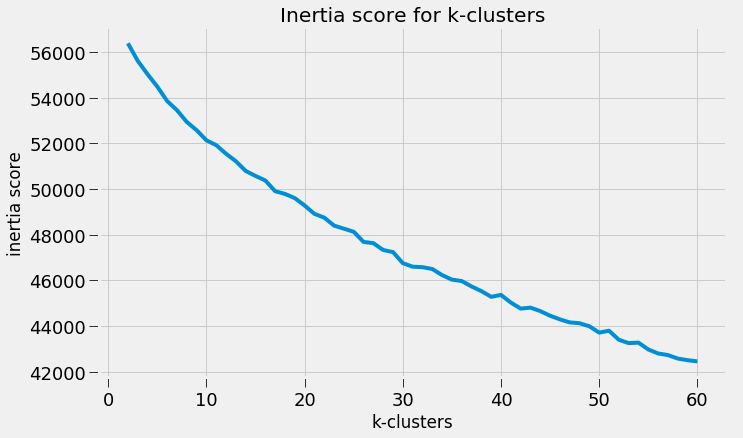

In [134]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

plt.plot(range(2,61),inertias)

plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Inertia score for k-clusters')
plt.xlabel('k-clusters')
plt.ylabel('inertia score');

In [23]:
%timeit

# Determine n_clusters by looking at silhouette scores

silhouette_scores = []
for n in range(10,21):    
    km = KMeans(n_clusters=n).fit(comments_norm_df)
    clusters = km.predict(comments_norm_df)
    sil_score = silhouette_score(comments_norm_df,clusters)
    silhouette_scores.append(sil_score)
    print('Silhouette score for {} clusters: '.format(n),sil_score)

Silhouette score for 10 clusters:  0.0361057
Silhouette score for 11 clusters:  0.0329192
Silhouette score for 12 clusters:  0.0381529
Silhouette score for 13 clusters:  0.0413628
Silhouette score for 14 clusters:  0.0403398
Silhouette score for 15 clusters:  0.046081
Silhouette score for 16 clusters:  0.0451869
Silhouette score for 17 clusters:  0.0502393
Silhouette score for 18 clusters:  0.0483195
Silhouette score for 19 clusters:  0.0474364
Silhouette score for 20 clusters:  0.0506261


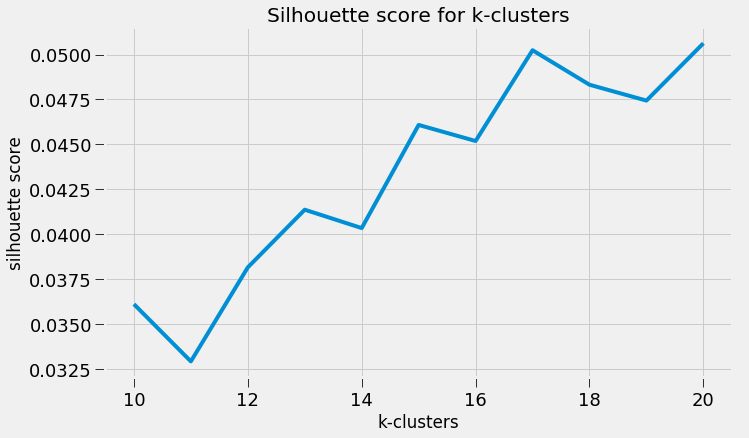

In [24]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

plt.plot(range(10,21),silhouette_scores)

plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Silhouette score for k-clusters')
plt.xlabel('k-clusters')
plt.ylabel('silhouette score');

# K-Means with 17 clusters

In [214]:
km = KMeans(n_clusters=17).fit(comments_norm_df)
clusters = km.predict(comments_norm_df)

In [215]:
# Get predictions from K-Means
preds = pd.Series(clusters)

In [216]:
# Group index numbers into their clusters
cluster_groups = []
for i in range(17):
    cluster_groups.append(list(preds[preds==i].index.values))

In [217]:
len(cluster_groups)

17

In [218]:
len(preds)

59248

In [219]:
comments_df = joblib.load('comments_top10_en.pkl')

In [220]:
# Drop NaN indices and reset index to compare with cluster predictions
comments_df.drop(comments_df.index[nan_index],inplace=True)
comments_df.reset_index(drop=True,inplace=True)

In [221]:
joblib.dump(comments_df,'final_comments.pkl')

['final_comments.pkl']

In [222]:
comments_df = joblib.load('final_comments.pkl')

In [223]:
corpus = joblib.load('corpus_gensim.pkl')

In [224]:
# Drop NaN indices and reset index to compare with cluster predictions

corpus.drop(corpus.index[nan_index],inplace=True)
corpus.reset_index(drop=True,inplace=True)

In [225]:
joblib.dump(corpus,'final_corpus.pkl')

['final_corpus.pkl']

In [226]:
corpus = joblib.load('final_corpus.pkl')

In [227]:
len(corpus)

59248

In [453]:
x = 700
for comment in corpus.iloc[cluster_groups[1]][x:x+10]:
    print(comment)
    print('\n')

everybodi read comment give 1 💵 buy new iphon X


buy iphon 4s tomorrow yay


buy note 8 thank


buy dummi br send link websit


buy dummi


shouldnt buy either


plan buy 8 announc go X announc


buy one headphon jack Oh wait


hrefhttpwwwyoutubecomresultssearchquery23toopricytoopricya buy PC 3 nintendo switch 2 xbox 3 game 2 ps4 pro 2 game


your go spend 900 buy iphon X




In [273]:
topics = ['Ugly','Buy','Im','??','iPhone','Apple','Samsung','f*ck','Unlock','Like','FaceID', 'Power Button',
          'Looks','iPhone 8 plus','HTML','iPhone X','Wireless Charger']

In [274]:
for i in range(17):
    print('Cluster Group {}: {}. Number of comments in cluster: {}'.format(i,topics[i],len(cluster_groups[i])))

Cluster Group 0: Ugly. Number of comments in cluster: 1020
Cluster Group 1: Buy. Number of comments in cluster: 2136
Cluster Group 2: Im. Number of comments in cluster: 1957
Cluster Group 3: ??. Number of comments in cluster: 22072
Cluster Group 4: iPhone. Number of comments in cluster: 5559
Cluster Group 5: Apple. Number of comments in cluster: 3930
Cluster Group 6: Samsung. Number of comments in cluster: 2649
Cluster Group 7: f*ck. Number of comments in cluster: 1113
Cluster Group 8: Unlock. Number of comments in cluster: 4597
Cluster Group 9: Like. Number of comments in cluster: 2481
Cluster Group 10: FaceID. Number of comments in cluster: 3448
Cluster Group 11: Power Button. Number of comments in cluster: 1358
Cluster Group 12: Looks. Number of comments in cluster: 2321
Cluster Group 13: iPhone 8 plus. Number of comments in cluster: 1264
Cluster Group 14: HTML. Number of comments in cluster: 1429
Cluster Group 15: iPhone X. Number of comments in cluster: 1257
Cluster Group 16: Wire

# Latent Dirichlet Allocation (LDA), Topic Modelling with GENSIM 

In [429]:
df = joblib.load('cleaned_text_df.pkl')

In [430]:
comments = df['Comments']

In [431]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(comments)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [432]:
counts = count_vectorizer.transform(comments).transpose()

In [433]:
counts.shape

(223448, 61877)

In [434]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

In [436]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [438]:
len(id2word)

223448

In [439]:
# Create lda model, pick 10 topics to start
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=10)

2017-11-02 16:02:28,472 : INFO : using symmetric alpha at 0.1
2017-11-02 16:02:28,476 : INFO : using symmetric eta at 4.47531416705e-06
2017-11-02 16:02:28,505 : INFO : using serial LDA version on this node
2017-11-02 16:02:37,830 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 61877 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-02 16:02:37,842 : INFO : PROGRESS: pass 0, at document #2000/61877
2017-11-02 16:02:39,923 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:02:40,176 : INFO : topic #6 (0.100): 0.024*"iphon" + 0.013*"br" + 0.009*"plu" + 0.008*"look" + 0.007*"like" + 0.006*"make" + 0.006*"appl" + 0.005*"use" + 0.005*"iphon plu" + 0.004*"buy"
2017-11-02 16:02:40,178 : INFO : topic #1 (0.100): 0.022*"iphon" + 0.011*"appl" + 0.009*"br" + 0.009*"buy" + 0.008*"like" + 0.005*"mak

2017-11-02 16:02:53,122 : INFO : topic #2 (0.100): 0.036*"iphon" + 0.011*"appl" + 0.008*"note" + 0.005*"wow" + 0.005*"china" + 0.005*"im" + 0.005*"pleas" + 0.004*"say" + 0.004*"samsung" + 0.003*"phone"
2017-11-02 16:02:53,125 : INFO : topic #7 (0.100): 0.026*"buy" + 0.018*"phone" + 0.018*"iphon" + 0.015*"appl" + 0.010*"better" + 0.010*"want" + 0.008*"dont" + 0.008*"samsung" + 0.007*"new" + 0.006*"good"
2017-11-02 16:02:53,127 : INFO : topic #0 (0.100): 0.035*"like" + 0.026*"iphon" + 0.016*"look" + 0.014*"dont" + 0.009*"look like" + 0.009*"appl" + 0.007*"android" + 0.007*"buy" + 0.006*"like iphon" + 0.006*"camera"
2017-11-02 16:02:53,130 : INFO : topic #4 (0.100): 0.043*"iphon" + 0.018*"look" + 0.018*"phone" + 0.014*"like" + 0.013*"samsung" + 0.011*"plu" + 0.008*"lol" + 0.007*"appl" + 0.007*"im" + 0.006*"think"
2017-11-02 16:02:53,132 : INFO : topic #1 (0.100): 0.018*"iphon" + 0.016*"clone" + 0.014*"appl" + 0.011*"ugli" + 0.008*"headphon" + 0.008*"design" + 0.007*"jack" + 0.007*"charg" 

2017-11-02 16:03:09,367 : INFO : topic #3 (0.100): 0.021*"phone" + 0.008*"fake" + 0.008*"power" + 0.008*"siri" + 0.008*"button" + 0.007*"fuck" + 0.006*"shit" + 0.006*"turn" + 0.005*"job" + 0.005*"hold"
2017-11-02 16:03:09,371 : INFO : topic #5 (0.100): 0.070*"br" + 0.024*"br br" + 0.020*"iphon" + 0.016*"video" + 0.012*"screen" + 0.011*"watch" + 0.007*"black" + 0.006*"bar" + 0.005*"edg" + 0.003*"iphon br"
2017-11-02 16:03:09,374 : INFO : topic #6 (0.100): 0.010*"bezel" + 0.007*"appl" + 0.007*"make" + 0.007*"notch" + 0.006*"iphon" + 0.006*"anyon" + 0.006*"dude" + 0.005*"look" + 0.005*"like" + 0.005*"use"
2017-11-02 16:03:09,383 : INFO : topic diff=0.361137, rho=0.277350
2017-11-02 16:03:09,400 : INFO : PROGRESS: pass 0, at document #28000/61877
2017-11-02 16:03:10,528 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:03:11,353 : INFO : topic #8 (0.100): 0.066*"iphon" + 0.024*"face" + 0.019*"id" + 0.014*"im" + 0.010*"unlock" + 0.010*"wait" + 0.010*

2017-11-02 16:03:21,746 : INFO : topic diff=0.433328, rho=0.229416
2017-11-02 16:03:25,022 : INFO : -12.303 per-word bound, 5052.6 perplexity estimate based on a held-out corpus of 2000 documents with 41511 words
2017-11-02 16:03:25,023 : INFO : PROGRESS: pass 0, at document #40000/61877
2017-11-02 16:03:26,061 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:03:27,031 : INFO : topic #0 (0.100): 0.038*"like" + 0.017*"dont" + 0.014*"look" + 0.011*"iphon" + 0.010*"home" + 0.010*"android" + 0.009*"button" + 0.008*"appl" + 0.007*"home button" + 0.007*"camera"
2017-11-02 16:03:27,035 : INFO : topic #3 (0.100): 0.027*"phone" + 0.018*"enabl" + 0.010*"restart" + 0.010*"turn" + 0.010*"job" + 0.009*"facial" + 0.008*"steve" + 0.007*"fingerprint" + 0.007*"steve job" + 0.006*"power"
2017-11-02 16:03:27,038 : INFO : topic #2 (0.100): 0.017*"finger" + 0.016*"iphon" + 0.011*"print" + 0.010*"appl" + 0.009*"finger print" + 0.008*"note" + 0.007*"scanner" + 0.007*

2017-11-02 16:03:39,466 : INFO : topic #2 (0.100): 0.016*"finger" + 0.016*"iphon" + 0.013*"print" + 0.010*"finger print" + 0.010*"scanner" + 0.009*"appl" + 0.007*"note" + 0.006*"lew" + 0.006*"iri" + 0.005*"samsung"
2017-11-02 16:03:39,471 : INFO : topic #5 (0.100): 0.071*"br" + 0.037*"pwm" + 0.037*"pwm pwm" + 0.027*"br br" + 0.019*"video" + 0.012*"screen" + 0.011*"iphon" + 0.009*"watch" + 0.003*"channel" + 0.003*"edg"
2017-11-02 16:03:39,475 : INFO : topic #3 (0.100): 0.023*"phone" + 0.016*"enabl" + 0.013*"fingerprint" + 0.011*"button" + 0.011*"power" + 0.009*"turn" + 0.009*"restart" + 0.009*"sensor" + 0.008*"job" + 0.008*"facial"
2017-11-02 16:03:39,479 : INFO : topic #8 (0.100): 0.049*"face" + 0.044*"id" + 0.025*"iphon" + 0.023*"touch" + 0.023*"unlock" + 0.021*"face id" + 0.020*"touch id" + 0.014*"passcod" + 0.014*"fail" + 0.012*"work"
2017-11-02 16:03:39,484 : INFO : topic #1 (0.100): 0.027*"appl" + 0.015*"ho" + 0.014*"copi" + 0.011*"jack" + 0.011*"headphon" + 0.010*"samsung" + 0.00

2017-11-02 16:03:54,512 : INFO : topic #4 (0.100): 0.045*"iphon" + 0.021*"look" + 0.018*"phone" + 0.017*"samsung" + 0.014*"like" + 0.012*"plu" + 0.011*"make" + 0.008*"galaxi" + 0.007*"appl" + 0.007*"im"
2017-11-02 16:03:54,516 : INFO : topic #2 (0.100): 0.021*"iphon" + 0.009*"finger" + 0.008*"appl" + 0.008*"note" + 0.008*"print" + 0.006*"finger print" + 0.005*"scanner" + 0.005*"say" + 0.005*"wait" + 0.005*"wow"
2017-11-02 16:03:54,519 : INFO : topic #1 (0.100): 0.023*"appl" + 0.018*"jack" + 0.017*"headphon" + 0.014*"headphon jack" + 0.014*"copi" + 0.011*"samsung" + 0.010*"charg" + 0.008*"iphon" + 0.007*"android" + 0.006*"design"
2017-11-02 16:03:54,523 : INFO : topic #9 (0.100): 0.023*"iphon" + 0.009*"year" + 0.008*"screen" + 0.007*"phone" + 0.007*"display" + 0.006*"skip" + 0.005*"nice" + 0.005*"ill" + 0.005*"stick" + 0.005*"featur"
2017-11-02 16:03:54,532 : INFO : topic diff=0.315160, rho=0.174240
2017-11-02 16:03:54,548 : INFO : PROGRESS: pass 1, at document #4000/61877
2017-11-02 16

2017-11-02 16:04:03,314 : INFO : topic #8 (0.100): 0.037*"iphon" + 0.033*"face" + 0.029*"id" + 0.015*"face id" + 0.013*"unlock" + 0.013*"im" + 0.012*"plz" + 0.012*"touch" + 0.011*"phone" + 0.010*"touch id"
2017-11-02 16:04:03,318 : INFO : topic #4 (0.100): 0.073*"iphon" + 0.025*"plu" + 0.019*"look" + 0.015*"phone" + 0.015*"like" + 0.013*"iphon plu" + 0.013*"samsung" + 0.009*"make" + 0.008*"im" + 0.008*"think"
2017-11-02 16:04:03,327 : INFO : topic diff=0.195052, rho=0.174240
2017-11-02 16:04:03,344 : INFO : PROGRESS: pass 1, at document #16000/61877
2017-11-02 16:04:04,005 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:04:04,547 : INFO : topic #6 (0.100): 0.006*"anyon" + 0.005*"make" + 0.005*"wtf" + 0.005*"bezel" + 0.005*"appl" + 0.004*"iphon" + 0.004*"video" + 0.004*"fingerprint" + 0.004*"dude" + 0.003*"like"
2017-11-02 16:04:04,551 : INFO : topic #4 (0.100): 0.074*"iphon" + 0.024*"plu" + 0.019*"look" + 0.015*"phone" + 0.015*"like" + 0.013*"

2017-11-02 16:04:13,325 : INFO : topic diff=0.307162, rho=0.174240
2017-11-02 16:04:13,342 : INFO : PROGRESS: pass 1, at document #28000/61877
2017-11-02 16:04:14,139 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:04:14,739 : INFO : topic #8 (0.100): 0.033*"iphon" + 0.030*"face" + 0.023*"id" + 0.014*"unlock" + 0.012*"im" + 0.012*"touch" + 0.011*"phone" + 0.011*"face id" + 0.010*"use" + 0.009*"wait"
2017-11-02 16:04:14,742 : INFO : topic #4 (0.100): 0.063*"iphon" + 0.024*"look" + 0.016*"phone" + 0.015*"like" + 0.014*"plu" + 0.012*"samsung" + 0.010*"make" + 0.007*"think" + 0.007*"lol" + 0.007*"im"
2017-11-02 16:04:14,747 : INFO : topic #2 (0.100): 0.024*"iphon" + 0.011*"note" + 0.007*"appl" + 0.006*"wow" + 0.005*"finger" + 0.005*"say" + 0.005*"marqu" + 0.005*"print" + 0.004*"wait" + 0.004*"china"
2017-11-02 16:04:14,750 : INFO : topic #6 (0.100): 0.010*"bezel" + 0.007*"anyon" + 0.006*"make" + 0.006*"dude" + 0.005*"appl" + 0.005*"fingerprint" + 

2017-11-02 16:04:26,278 : INFO : topic #8 (0.100): 0.050*"face" + 0.041*"id" + 0.023*"face id" + 0.023*"unlock" + 0.017*"touch" + 0.016*"phone" + 0.016*"iphon" + 0.015*"fail" + 0.015*"touch id" + 0.013*"work"
2017-11-02 16:04:26,282 : INFO : topic #4 (0.100): 0.048*"iphon" + 0.018*"look" + 0.016*"phone" + 0.015*"like" + 0.011*"make" + 0.011*"samsung" + 0.009*"plu" + 0.009*"think" + 0.008*"appl" + 0.007*"lol"
2017-11-02 16:04:26,285 : INFO : topic #6 (0.100): 0.009*"fingerprint" + 0.008*"scanner" + 0.008*"make" + 0.006*"bezel" + 0.006*"appl" + 0.006*"fingerprint scanner" + 0.006*"dude" + 0.005*"messag" + 0.005*"anyon" + 0.005*"touchid"
2017-11-02 16:04:26,289 : INFO : topic #1 (0.100): 0.022*"appl" + 0.021*"ho" + 0.013*"ho ho" + 0.011*"charg" + 0.010*"swipe" + 0.009*"jack" + 0.008*"headphon" + 0.007*"copi" + 0.007*"wireless" + 0.007*"headphon jack"
2017-11-02 16:04:26,298 : INFO : topic diff=0.336948, rho=0.174240
2017-11-02 16:04:26,318 : INFO : PROGRESS: pass 1, at document #42000/618

2017-11-02 16:04:35,682 : INFO : topic #5 (0.100): 0.073*"br" + 0.034*"pwm" + 0.034*"pwm pwm" + 0.027*"br br" + 0.019*"video" + 0.011*"screen" + 0.011*"iphon" + 0.010*"watch" + 0.003*"channel" + 0.003*"edg"
2017-11-02 16:04:35,686 : INFO : topic #2 (0.100): 0.017*"finger" + 0.016*"iphon" + 0.013*"print" + 0.010*"finger print" + 0.010*"scanner" + 0.008*"appl" + 0.007*"note" + 0.007*"lew" + 0.006*"iri" + 0.005*"samsung"
2017-11-02 16:04:35,696 : INFO : topic diff=0.293306, rho=0.174240
2017-11-02 16:04:35,715 : INFO : PROGRESS: pass 1, at document #54000/61877
2017-11-02 16:04:36,557 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:04:37,273 : INFO : topic #0 (0.100): 0.044*"like" + 0.022*"look" + 0.018*"dont" + 0.012*"android" + 0.011*"iphon" + 0.010*"look like" + 0.010*"home" + 0.010*"button" + 0.007*"camera" + 0.007*"appl"
2017-11-02 16:04:37,278 : INFO : topic #4 (0.100): 0.048*"iphon" + 0.019*"look" + 0.016*"like" + 0.016*"samsung" + 0.015*"

2017-11-02 16:04:50,181 : INFO : topic #3 (0.100): 0.021*"phone" + 0.010*"button" + 0.009*"fingerprint" + 0.009*"job" + 0.008*"power" + 0.007*"turn" + 0.007*"steve" + 0.007*"enabl" + 0.006*"sensor" + 0.006*"close"
2017-11-02 16:04:50,191 : INFO : topic diff=0.274626, rho=0.171654
2017-11-02 16:04:50,210 : INFO : PROGRESS: pass 2, at document #4000/61877
2017-11-02 16:04:51,136 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:04:51,787 : INFO : topic #3 (0.100): 0.021*"phone" + 0.009*"job" + 0.009*"button" + 0.008*"fingerprint" + 0.007*"turn" + 0.007*"power" + 0.006*"steve" + 0.005*"sensor" + 0.005*"enabl" + 0.005*"steve job"
2017-11-02 16:04:51,792 : INFO : topic #7 (0.100): 0.030*"appl" + 0.028*"phone" + 0.026*"buy" + 0.015*"iphon" + 0.014*"samsung" + 0.012*"want" + 0.012*"better" + 0.011*"new" + 0.009*"price" + 0.008*"dont"
2017-11-02 16:04:51,796 : INFO : topic #8 (0.100): 0.042*"face" + 0.033*"id" + 0.021*"unlock" + 0.018*"phone" + 0.016*"i

2017-11-02 16:05:00,389 : INFO : topic #4 (0.100): 0.090*"iphon" + 0.025*"plu" + 0.019*"look" + 0.016*"like" + 0.014*"phone" + 0.013*"iphon plu" + 0.011*"samsung" + 0.009*"im" + 0.009*"iphon iphon" + 0.008*"make"
2017-11-02 16:05:00,394 : INFO : topic #8 (0.100): 0.031*"face" + 0.029*"id" + 0.022*"iphon" + 0.014*"face id" + 0.014*"unlock" + 0.014*"phone" + 0.013*"plz" + 0.012*"touch" + 0.011*"im" + 0.010*"touch id"
2017-11-02 16:05:00,398 : INFO : topic #1 (0.100): 0.020*"appl" + 0.014*"clone" + 0.012*"headphon" + 0.011*"jack" + 0.011*"ugli" + 0.010*"charg" + 0.009*"iphon" + 0.009*"headphon jack" + 0.009*"copi" + 0.009*"samsung"
2017-11-02 16:05:00,402 : INFO : topic #0 (0.100): 0.044*"like" + 0.023*"look" + 0.018*"iphon" + 0.017*"dont" + 0.011*"look like" + 0.011*"home" + 0.010*"button" + 0.010*"camera" + 0.009*"android" + 0.009*"home button"
2017-11-02 16:05:00,406 : INFO : topic #3 (0.100): 0.019*"fake" + 0.019*"phone" + 0.008*"job" + 0.006*"steve" + 0.005*"bro" + 0.005*"fuck" + 0.0

2017-11-02 16:05:09,984 : INFO : topic #0 (0.100): 0.044*"like" + 0.027*"look" + 0.016*"dont" + 0.015*"iphon" + 0.014*"home" + 0.012*"button" + 0.011*"look like" + 0.011*"camera" + 0.011*"android" + 0.011*"gestur"
2017-11-02 16:05:09,989 : INFO : topic #4 (0.100): 0.075*"iphon" + 0.023*"look" + 0.016*"like" + 0.015*"plu" + 0.015*"phone" + 0.011*"samsung" + 0.009*"make" + 0.008*"iphon iphon" + 0.008*"im" + 0.007*"think"
2017-11-02 16:05:09,992 : INFO : topic #9 (0.100): 0.026*"iphon" + 0.010*"skip" + 0.009*"window" + 0.008*"year" + 0.007*"screen" + 0.007*"phone" + 0.007*"nice" + 0.007*"display" + 0.006*"appl" + 0.005*"review"
2017-11-02 16:05:10,000 : INFO : topic diff=0.239672, rho=0.171654
2017-11-02 16:05:10,020 : INFO : PROGRESS: pass 2, at document #30000/61877
2017-11-02 16:05:10,768 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:05:11,311 : INFO : topic #9 (0.100): 0.026*"iphon" + 0.010*"skip" + 0.009*"year" + 0.009*"window" + 0.008*"ph

2017-11-02 16:05:20,992 : INFO : topic #5 (0.100): 0.083*"br" + 0.031*"br br" + 0.019*"video" + 0.013*"iphon" + 0.011*"watch" + 0.009*"screen" + 0.005*"black" + 0.004*"bar" + 0.003*"edg" + 0.003*"br iphon"
2017-11-02 16:05:21,001 : INFO : topic diff=0.308408, rho=0.171654
2017-11-02 16:05:21,020 : INFO : PROGRESS: pass 2, at document #42000/61877
2017-11-02 16:05:21,825 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:05:22,541 : INFO : topic #9 (0.100): 0.020*"iphon" + 0.009*"year" + 0.007*"appl" + 0.006*"phone" + 0.006*"window" + 0.006*"screen" + 0.006*"skip" + 0.005*"display" + 0.005*"thing" + 0.005*"featur"
2017-11-02 16:05:22,545 : INFO : topic #2 (0.100): 0.019*"finger" + 0.016*"iphon" + 0.011*"print" + 0.009*"finger print" + 0.009*"note" + 0.008*"scanner" + 0.008*"appl" + 0.007*"iri" + 0.006*"attempt" + 0.006*"wipe"
2017-11-02 16:05:22,548 : INFO : topic #7 (0.100): 0.032*"appl" + 0.025*"phone" + 0.020*"buy" + 0.012*"iphon" + 0.010*"sams

2017-11-02 16:05:31,777 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:05:32,517 : INFO : topic #5 (0.100): 0.074*"br" + 0.029*"pwm" + 0.029*"pwm pwm" + 0.029*"br br" + 0.020*"video" + 0.012*"screen" + 0.010*"iphon" + 0.010*"watch" + 0.004*"channel" + 0.003*"edg"
2017-11-02 16:05:32,521 : INFO : topic #2 (0.100): 0.018*"finger" + 0.015*"iphon" + 0.014*"print" + 0.011*"finger print" + 0.011*"scanner" + 0.008*"lew" + 0.007*"appl" + 0.007*"note" + 0.005*"iri" + 0.005*"samsung"
2017-11-02 16:05:32,524 : INFO : topic #4 (0.100): 0.054*"iphon" + 0.019*"look" + 0.016*"like" + 0.014*"phone" + 0.014*"samsung" + 0.012*"make" + 0.009*"plu" + 0.009*"think" + 0.008*"im" + 0.008*"appl"
2017-11-02 16:05:32,527 : INFO : topic #8 (0.100): 0.045*"face" + 0.042*"id" + 0.023*"unlock" + 0.022*"touch" + 0.019*"touch id" + 0.019*"face id" + 0.017*"phone" + 0.013*"work" + 0.013*"fail" + 0.012*"passcod"
2017-11-02 16:05:32,531 : INFO : topic #9 (0.100): 0.018*"iphon"

2017-11-02 16:05:46,460 : INFO : topic #1 (0.100): 0.023*"appl" + 0.017*"jack" + 0.016*"headphon" + 0.015*"copi" + 0.013*"headphon jack" + 0.011*"samsung" + 0.011*"charg" + 0.006*"android" + 0.006*"wireless" + 0.006*"design"
2017-11-02 16:05:46,463 : INFO : topic #8 (0.100): 0.042*"face" + 0.033*"id" + 0.022*"unlock" + 0.019*"phone" + 0.016*"touch" + 0.015*"face id" + 0.013*"touch id" + 0.013*"iphon" + 0.011*"use" + 0.010*"work"
2017-11-02 16:05:46,466 : INFO : topic #3 (0.100): 0.020*"phone" + 0.009*"job" + 0.009*"button" + 0.008*"fingerprint" + 0.007*"turn" + 0.007*"power" + 0.007*"steve" + 0.005*"sensor" + 0.005*"enabl" + 0.005*"steve job"
2017-11-02 16:05:46,469 : INFO : topic #6 (0.100): 0.007*"prototyp" + 0.007*"fingerprint" + 0.007*"scanner" + 0.006*"anyon" + 0.006*"make" + 0.006*"bezel" + 0.006*"fingerprint scanner" + 0.004*"video" + 0.004*"appl" + 0.004*"wtf"
2017-11-02 16:05:46,474 : INFO : topic #2 (0.100): 0.021*"iphon" + 0.009*"finger" + 0.008*"note" + 0.007*"appl" + 0.007

2017-11-02 16:05:54,625 : INFO : topic #9 (0.100): 0.029*"iphon" + 0.008*"year" + 0.007*"screen" + 0.007*"skip" + 0.006*"phone" + 0.006*"display" + 0.005*"nice" + 0.005*"ill" + 0.005*"stick" + 0.005*"window"
2017-11-02 16:05:54,629 : INFO : topic #6 (0.100): 0.006*"anyon" + 0.005*"make" + 0.005*"bezel" + 0.005*"video" + 0.004*"wtf" + 0.004*"appl" + 0.004*"fingerprint" + 0.004*"dude" + 0.004*"scanner" + 0.004*"like"
2017-11-02 16:05:54,634 : INFO : topic #8 (0.100): 0.032*"face" + 0.029*"id" + 0.018*"iphon" + 0.014*"unlock" + 0.014*"phone" + 0.014*"face id" + 0.013*"plz" + 0.012*"touch" + 0.010*"touch id" + 0.009*"plz plz"
2017-11-02 16:05:54,649 : INFO : topic diff=0.158598, rho=0.169180
2017-11-02 16:05:54,669 : INFO : PROGRESS: pass 3, at document #18000/61877
2017-11-02 16:05:55,737 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:05:56,601 : INFO : topic #9 (0.100): 0.028*"iphon" + 0.007*"year" + 0.007*"screen" + 0.007*"phone" + 0.006*"skip

2017-11-02 16:06:06,326 : INFO : topic #2 (0.100): 0.023*"iphon" + 0.011*"note" + 0.007*"wow" + 0.006*"appl" + 0.005*"finger" + 0.005*"marqu" + 0.005*"print" + 0.005*"china" + 0.004*"pixel" + 0.004*"wait"
2017-11-02 16:06:06,335 : INFO : topic diff=0.225309, rho=0.169180
2017-11-02 16:06:06,351 : INFO : PROGRESS: pass 3, at document #30000/61877
2017-11-02 16:06:07,170 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:06:07,724 : INFO : topic #1 (0.100): 0.021*"appl" + 0.015*"charg" + 0.011*"copi" + 0.011*"ugli" + 0.010*"swipe" + 0.010*"wireless" + 0.010*"jack" + 0.010*"headphon" + 0.009*"clone" + 0.009*"design"
2017-11-02 16:06:07,729 : INFO : topic #9 (0.100): 0.025*"iphon" + 0.010*"skip" + 0.009*"window" + 0.008*"year" + 0.008*"phone" + 0.008*"screen" + 0.007*"display" + 0.007*"nice" + 0.006*"appl" + 0.005*"review"
2017-11-02 16:06:07,732 : INFO : topic #5 (0.100): 0.075*"br" + 0.027*"br br" + 0.020*"video" + 0.016*"iphon" + 0.012*"watch" + 0

2017-11-02 16:06:18,565 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:06:19,222 : INFO : topic #1 (0.100): 0.027*"ho" + 0.022*"appl" + 0.017*"ho ho" + 0.010*"charg" + 0.009*"swipe" + 0.008*"jack" + 0.008*"headphon" + 0.008*"copi" + 0.007*"headphon jack" + 0.007*"wireless"
2017-11-02 16:06:19,226 : INFO : topic #2 (0.100): 0.019*"finger" + 0.016*"iphon" + 0.011*"print" + 0.009*"finger print" + 0.009*"note" + 0.008*"scanner" + 0.007*"iri" + 0.007*"appl" + 0.006*"attempt" + 0.006*"wipe"
2017-11-02 16:06:19,230 : INFO : topic #9 (0.100): 0.019*"iphon" + 0.009*"year" + 0.007*"appl" + 0.006*"phone" + 0.006*"window" + 0.006*"skip" + 0.006*"screen" + 0.005*"display" + 0.005*"thing" + 0.004*"set"
2017-11-02 16:06:19,234 : INFO : topic #7 (0.100): 0.032*"appl" + 0.025*"phone" + 0.020*"buy" + 0.012*"iphon" + 0.011*"samsung" + 0.010*"better" + 0.009*"new" + 0.009*"want" + 0.008*"price" + 0.008*"dont"
2017-11-02 16:06:19,237 : INFO : topic #5 (0.100): 0.

2017-11-02 16:06:28,616 : INFO : topic #8 (0.100): 0.045*"face" + 0.042*"id" + 0.024*"unlock" + 0.022*"touch" + 0.019*"touch id" + 0.019*"face id" + 0.017*"phone" + 0.014*"work" + 0.013*"fail" + 0.012*"passcod"
2017-11-02 16:06:28,620 : INFO : topic #3 (0.100): 0.017*"phone" + 0.015*"fingerprint" + 0.014*"button" + 0.014*"enabl" + 0.013*"power" + 0.010*"sensor" + 0.010*"power button" + 0.009*"turn" + 0.008*"job" + 0.008*"restart"
2017-11-02 16:06:28,624 : INFO : topic #0 (0.100): 0.043*"like" + 0.022*"look" + 0.018*"dont" + 0.011*"android" + 0.010*"look like" + 0.010*"home" + 0.010*"button" + 0.010*"iphon" + 0.008*"camera" + 0.007*"appl"
2017-11-02 16:06:28,633 : INFO : topic diff=0.223060, rho=0.169180
2017-11-02 16:06:28,649 : INFO : PROGRESS: pass 3, at document #56000/61877
2017-11-02 16:06:29,363 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:06:30,001 : INFO : topic #9 (0.100): 0.018*"iphon" + 0.010*"screen" + 0.009*"year" + 0.008*"disp

2017-11-02 16:06:41,078 : INFO : topic #4 (0.100): 0.077*"iphon" + 0.019*"look" + 0.017*"plu" + 0.016*"like" + 0.015*"phone" + 0.013*"samsung" + 0.010*"im" + 0.009*"make" + 0.008*"iphon plu" + 0.007*"new"
2017-11-02 16:06:41,082 : INFO : topic #3 (0.100): 0.020*"phone" + 0.009*"button" + 0.009*"job" + 0.008*"fingerprint" + 0.007*"turn" + 0.007*"power" + 0.007*"steve" + 0.006*"enabl" + 0.005*"sensor" + 0.005*"steve job"
2017-11-02 16:06:41,091 : INFO : topic diff=0.210500, rho=0.166809
2017-11-02 16:06:41,107 : INFO : PROGRESS: pass 4, at document #6000/61877
2017-11-02 16:06:41,875 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:06:42,422 : INFO : topic #1 (0.100): 0.022*"appl" + 0.016*"jack" + 0.015*"headphon" + 0.013*"copi" + 0.012*"headphon jack" + 0.012*"charg" + 0.011*"samsung" + 0.007*"wireless" + 0.006*"android" + 0.006*"design"
2017-11-02 16:06:42,425 : INFO : topic #6 (0.100): 0.007*"prototyp" + 0.006*"anyon" + 0.006*"fingerprint" + 0

2017-11-02 16:06:48,919 : INFO : topic diff=0.151063, rho=0.166809
2017-11-02 16:06:48,934 : INFO : PROGRESS: pass 4, at document #18000/61877
2017-11-02 16:06:49,604 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:06:50,152 : INFO : topic #9 (0.100): 0.027*"iphon" + 0.007*"year" + 0.007*"screen" + 0.007*"phone" + 0.006*"skip" + 0.006*"display" + 0.005*"nice" + 0.005*"ill" + 0.004*"appl" + 0.004*"im"
2017-11-02 16:06:50,154 : INFO : topic #6 (0.100): 0.006*"anyon" + 0.005*"video" + 0.005*"wtf" + 0.005*"make" + 0.004*"dude" + 0.004*"bezel" + 0.004*"like" + 0.003*"appl" + 0.003*"fingerprint" + 0.003*"prototyp"
2017-11-02 16:06:50,158 : INFO : topic #0 (0.100): 0.045*"like" + 0.027*"look" + 0.017*"iphon" + 0.016*"dont" + 0.013*"look like" + 0.011*"camera" + 0.010*"home" + 0.009*"button" + 0.009*"android" + 0.008*"home button"
2017-11-02 16:06:50,162 : INFO : topic #4 (0.100): 0.095*"iphon" + 0.024*"plu" + 0.020*"look" + 0.018*"like" + 0.013*"phon

2017-11-02 16:07:00,388 : INFO : topic #7 (0.100): 0.031*"appl" + 0.028*"phone" + 0.022*"buy" + 0.015*"iphon" + 0.012*"samsung" + 0.011*"price" + 0.010*"better" + 0.010*"want" + 0.010*"new" + 0.007*"peopl"
2017-11-02 16:07:00,390 : INFO : topic #6 (0.100): 0.012*"bezel" + 0.007*"dude" + 0.007*"anyon" + 0.006*"make" + 0.005*"fingerprint" + 0.005*"wtf" + 0.004*"scanner" + 0.004*"appl" + 0.004*"notch" + 0.004*"video"
2017-11-02 16:07:00,395 : INFO : topic #4 (0.100): 0.080*"iphon" + 0.023*"look" + 0.017*"like" + 0.015*"phone" + 0.014*"plu" + 0.010*"samsung" + 0.009*"im" + 0.008*"make" + 0.008*"think" + 0.008*"iphon iphon"
2017-11-02 16:07:00,398 : INFO : topic #1 (0.100): 0.020*"appl" + 0.015*"charg" + 0.011*"copi" + 0.011*"ugli" + 0.010*"swipe" + 0.010*"wireless" + 0.010*"jack" + 0.010*"headphon" + 0.009*"clone" + 0.009*"design"
2017-11-02 16:07:00,407 : INFO : topic diff=0.217681, rho=0.166809
2017-11-02 16:07:00,424 : INFO : PROGRESS: pass 4, at document #32000/61877
2017-11-02 16:07:0

2017-11-02 16:07:11,577 : INFO : topic #6 (0.100): 0.009*"fingerprint" + 0.008*"scanner" + 0.008*"make" + 0.006*"messag" + 0.006*"fingerprint scanner" + 0.005*"dude" + 0.005*"touchid" + 0.005*"bezel" + 0.005*"appl" + 0.005*"anyon"
2017-11-02 16:07:11,579 : INFO : topic #1 (0.100): 0.027*"ho" + 0.022*"appl" + 0.017*"ho ho" + 0.010*"charg" + 0.009*"swipe" + 0.009*"jack" + 0.008*"headphon" + 0.008*"copi" + 0.007*"headphon jack" + 0.007*"wireless"
2017-11-02 16:07:11,589 : INFO : topic diff=0.285780, rho=0.166809
2017-11-02 16:07:11,606 : INFO : PROGRESS: pass 4, at document #44000/61877
2017-11-02 16:07:12,399 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:07:13,020 : INFO : topic #4 (0.100): 0.058*"iphon" + 0.017*"look" + 0.016*"like" + 0.014*"phone" + 0.010*"make" + 0.010*"plu" + 0.009*"think" + 0.008*"samsung" + 0.008*"makeup" + 0.008*"im"
2017-11-02 16:07:13,023 : INFO : topic #0 (0.100): 0.040*"like" + 0.019*"look" + 0.018*"dont" + 0.011*"h

2017-11-02 16:07:20,614 : INFO : topic diff=0.213244, rho=0.166809
2017-11-02 16:07:20,629 : INFO : PROGRESS: pass 4, at document #56000/61877
2017-11-02 16:07:21,322 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:07:21,939 : INFO : topic #1 (0.100): 0.026*"appl" + 0.017*"copi" + 0.013*"jack" + 0.013*"headphon" + 0.011*"samsung" + 0.011*"ho" + 0.010*"headphon jack" + 0.008*"charg" + 0.007*"android" + 0.007*"ho ho"
2017-11-02 16:07:21,943 : INFO : topic #4 (0.100): 0.060*"iphon" + 0.019*"look" + 0.018*"like" + 0.014*"phone" + 0.013*"samsung" + 0.011*"make" + 0.010*"plu" + 0.009*"im" + 0.009*"think" + 0.007*"appl"
2017-11-02 16:07:21,948 : INFO : topic #7 (0.100): 0.037*"appl" + 0.026*"phone" + 0.018*"buy" + 0.017*"samsung" + 0.012*"iphon" + 0.011*"better" + 0.010*"want" + 0.009*"new" + 0.008*"dont" + 0.008*"peopl"
2017-11-02 16:07:21,951 : INFO : topic #6 (0.100): 0.016*"prototyp" + 0.013*"scanner" + 0.012*"fingerprint" + 0.011*"fingerprint sc

2017-11-02 16:07:32,983 : INFO : PROGRESS: pass 5, at document #6000/61877
2017-11-02 16:07:33,821 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:07:34,370 : INFO : topic #5 (0.100): 0.093*"br" + 0.041*"br br" + 0.018*"video" + 0.014*"iphon" + 0.009*"watch" + 0.009*"screen" + 0.008*"pwm" + 0.008*"pwm pwm" + 0.005*"black" + 0.003*"br iphon"
2017-11-02 16:07:34,374 : INFO : topic #6 (0.100): 0.007*"prototyp" + 0.006*"fingerprint" + 0.006*"anyon" + 0.006*"scanner" + 0.005*"bezel" + 0.005*"fingerprint scanner" + 0.005*"make" + 0.005*"video" + 0.004*"wtf" + 0.004*"dude"
2017-11-02 16:07:34,378 : INFO : topic #2 (0.100): 0.021*"iphon" + 0.009*"note" + 0.008*"finger" + 0.007*"appl" + 0.006*"print" + 0.005*"finger print" + 0.005*"wow" + 0.005*"scanner" + 0.004*"samsung" + 0.004*"wait"
2017-11-02 16:07:34,382 : INFO : topic #0 (0.100): 0.039*"like" + 0.021*"look" + 0.016*"dont" + 0.015*"home" + 0.013*"button" + 0.012*"iphon" + 0.012*"home button" + 0.

2017-11-02 16:07:42,446 : INFO : topic #6 (0.100): 0.006*"anyon" + 0.005*"video" + 0.005*"wtf" + 0.005*"make" + 0.004*"dude" + 0.004*"bezel" + 0.004*"like" + 0.003*"appl" + 0.003*"fingerprint" + 0.003*"prototyp"
2017-11-02 16:07:42,450 : INFO : topic #7 (0.100): 0.034*"buy" + 0.029*"appl" + 0.025*"phone" + 0.018*"iphon" + 0.014*"want" + 0.012*"samsung" + 0.011*"better" + 0.009*"price" + 0.009*"new" + 0.008*"dont"
2017-11-02 16:07:42,453 : INFO : topic #3 (0.100): 0.022*"fake" + 0.017*"phone" + 0.007*"job" + 0.007*"fuck" + 0.006*"bro" + 0.005*"steve" + 0.005*"turn" + 0.004*"button" + 0.004*"power" + 0.004*"steve job"
2017-11-02 16:07:42,457 : INFO : topic #1 (0.100): 0.023*"clone" + 0.018*"appl" + 0.014*"ugli" + 0.010*"headphon" + 0.010*"jack" + 0.010*"copi" + 0.009*"charg" + 0.008*"headphon jack" + 0.008*"design" + 0.008*"samsung"
2017-11-02 16:07:42,467 : INFO : topic diff=0.142595, rho=0.164536
2017-11-02 16:07:44,242 : INFO : -11.913 per-word bound, 3856.1 perplexity estimate based 

2017-11-02 16:07:52,162 : INFO : topic #7 (0.100): 0.031*"appl" + 0.028*"phone" + 0.021*"buy" + 0.015*"iphon" + 0.012*"samsung" + 0.011*"price" + 0.011*"better" + 0.010*"want" + 0.010*"new" + 0.007*"peopl"
2017-11-02 16:07:52,166 : INFO : topic #2 (0.100): 0.022*"iphon" + 0.012*"note" + 0.006*"appl" + 0.006*"wow" + 0.006*"finger" + 0.006*"marqu" + 0.005*"pixel" + 0.005*"print" + 0.004*"wait" + 0.004*"finger print"
2017-11-02 16:07:52,175 : INFO : topic diff=0.208182, rho=0.164536
2017-11-02 16:07:52,192 : INFO : PROGRESS: pass 5, at document #32000/61877
2017-11-02 16:07:52,953 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:07:53,478 : INFO : topic #5 (0.100): 0.074*"br" + 0.027*"br br" + 0.021*"video" + 0.015*"iphon" + 0.011*"watch" + 0.011*"screen" + 0.009*"black" + 0.008*"bar" + 0.004*"edg" + 0.004*"br iphon"
2017-11-02 16:07:53,482 : INFO : topic #8 (0.100): 0.032*"face" + 0.026*"id" + 0.017*"iphon" + 0.016*"unlock" + 0.014*"touch" + 0.01

2017-11-02 16:08:03,191 : INFO : topic diff=0.273955, rho=0.164536
2017-11-02 16:08:03,209 : INFO : PROGRESS: pass 5, at document #44000/61877
2017-11-02 16:08:04,046 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:08:04,660 : INFO : topic #6 (0.100): 0.009*"fingerprint" + 0.009*"scanner" + 0.007*"make" + 0.006*"fingerprint scanner" + 0.006*"messag" + 0.006*"touchid" + 0.005*"dude" + 0.005*"appl" + 0.005*"anyon" + 0.005*"bezel"
2017-11-02 16:08:04,663 : INFO : topic #7 (0.100): 0.032*"appl" + 0.025*"phone" + 0.019*"buy" + 0.012*"iphon" + 0.011*"samsung" + 0.010*"better" + 0.009*"new" + 0.009*"want" + 0.008*"dont" + 0.008*"price"
2017-11-02 16:08:04,666 : INFO : topic #3 (0.100): 0.021*"enabl" + 0.019*"phone" + 0.012*"restart" + 0.011*"turn" + 0.011*"job" + 0.009*"steve" + 0.008*"fingerprint" + 0.008*"facial" + 0.008*"fuck" + 0.007*"steve job"
2017-11-02 16:08:04,670 : INFO : topic #2 (0.100): 0.019*"finger" + 0.015*"iphon" + 0.011*"print" + 0.

2017-11-02 16:08:13,443 : INFO : topic #7 (0.100): 0.037*"appl" + 0.026*"phone" + 0.018*"buy" + 0.017*"samsung" + 0.012*"iphon" + 0.011*"better" + 0.010*"want" + 0.009*"new" + 0.008*"dont" + 0.008*"peopl"
2017-11-02 16:08:13,447 : INFO : topic #3 (0.100): 0.017*"phone" + 0.014*"button" + 0.013*"fingerprint" + 0.013*"enabl" + 0.012*"power" + 0.009*"sensor" + 0.009*"turn" + 0.009*"power button" + 0.008*"job" + 0.007*"restart"
2017-11-02 16:08:13,452 : INFO : topic #4 (0.100): 0.061*"iphon" + 0.019*"look" + 0.018*"like" + 0.014*"phone" + 0.013*"samsung" + 0.010*"make" + 0.010*"plu" + 0.009*"im" + 0.009*"think" + 0.008*"appl"
2017-11-02 16:08:13,454 : INFO : topic #1 (0.100): 0.026*"appl" + 0.017*"copi" + 0.013*"jack" + 0.013*"headphon" + 0.011*"samsung" + 0.011*"ho" + 0.010*"headphon jack" + 0.008*"charg" + 0.007*"android" + 0.007*"ho ho"
2017-11-02 16:08:13,463 : INFO : topic diff=0.192608, rho=0.164536
2017-11-02 16:08:13,479 : INFO : PROGRESS: pass 5, at document #58000/61877
2017-11-0

2017-11-02 16:08:26,521 : INFO : topic #7 (0.100): 0.030*"appl" + 0.028*"buy" + 0.028*"phone" + 0.015*"iphon" + 0.015*"samsung" + 0.012*"want" + 0.012*"better" + 0.010*"new" + 0.010*"price" + 0.009*"dont"
2017-11-02 16:08:26,525 : INFO : topic #4 (0.100): 0.082*"iphon" + 0.019*"plu" + 0.019*"look" + 0.017*"like" + 0.015*"phone" + 0.012*"samsung" + 0.010*"im" + 0.008*"iphon plu" + 0.008*"make" + 0.007*"new"
2017-11-02 16:08:26,528 : INFO : topic #0 (0.100): 0.039*"like" + 0.021*"look" + 0.016*"dont" + 0.015*"home" + 0.013*"button" + 0.012*"iphon" + 0.012*"home button" + 0.011*"android" + 0.009*"look like" + 0.008*"camera"
2017-11-02 16:08:26,532 : INFO : topic #6 (0.100): 0.007*"prototyp" + 0.007*"fingerprint" + 0.006*"anyon" + 0.006*"scanner" + 0.005*"bezel" + 0.005*"fingerprint scanner" + 0.005*"make" + 0.005*"video" + 0.004*"dude" + 0.004*"wtf"
2017-11-02 16:08:26,542 : INFO : topic diff=0.211137, rho=0.162353
2017-11-02 16:08:26,559 : INFO : PROGRESS: pass 6, at document #8000/61877

2017-11-02 16:08:35,316 : INFO : topic #3 (0.100): 0.022*"fake" + 0.016*"phone" + 0.007*"job" + 0.007*"fuck" + 0.006*"bro" + 0.005*"steve" + 0.005*"turn" + 0.004*"button" + 0.004*"power" + 0.004*"steve job"
2017-11-02 16:08:35,320 : INFO : topic #0 (0.100): 0.044*"like" + 0.026*"look" + 0.016*"dont" + 0.016*"iphon" + 0.012*"look like" + 0.010*"camera" + 0.010*"home" + 0.009*"button" + 0.009*"android" + 0.008*"home button"
2017-11-02 16:08:35,329 : INFO : topic diff=0.136360, rho=0.162353
2017-11-02 16:08:37,302 : INFO : -11.886 per-word bound, 3783.9 perplexity estimate based on a held-out corpus of 2000 documents with 18799 words
2017-11-02 16:08:37,303 : INFO : PROGRESS: pass 6, at document #20000/61877
2017-11-02 16:08:37,956 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:08:38,527 : INFO : topic #9 (0.100): 0.025*"iphon" + 0.007*"screen" + 0.006*"phone" + 0.006*"year" + 0.006*"display" + 0.006*"skip" + 0.006*"nice" + 0.005*"hi" + 0.005*"a

2017-11-02 16:08:46,001 : INFO : topic diff=0.199098, rho=0.162353
2017-11-02 16:08:46,024 : INFO : PROGRESS: pass 6, at document #32000/61877
2017-11-02 16:08:47,185 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:08:47,706 : INFO : topic #5 (0.100): 0.074*"br" + 0.027*"br br" + 0.021*"video" + 0.015*"iphon" + 0.011*"watch" + 0.011*"screen" + 0.009*"black" + 0.007*"bar" + 0.004*"edg" + 0.004*"br iphon"
2017-11-02 16:08:47,710 : INFO : topic #1 (0.100): 0.021*"appl" + 0.015*"charg" + 0.011*"copi" + 0.011*"wireless" + 0.011*"swipe" + 0.010*"jack" + 0.010*"ugli" + 0.010*"headphon" + 0.009*"headphon jack" + 0.008*"wireless charg"
2017-11-02 16:08:47,714 : INFO : topic #3 (0.100): 0.020*"phone" + 0.011*"power" + 0.011*"button" + 0.010*"siri" + 0.009*"fuck" + 0.009*"turn" + 0.008*"job" + 0.007*"hold" + 0.007*"fake" + 0.006*"power button"
2017-11-02 16:08:47,717 : INFO : topic #6 (0.100): 0.013*"bezel" + 0.008*"dude" + 0.007*"anyon" + 0.006*"fingerp

2017-11-02 16:09:00,171 : INFO : topic #1 (0.100): 0.027*"ho" + 0.022*"appl" + 0.017*"ho ho" + 0.010*"charg" + 0.009*"swipe" + 0.008*"jack" + 0.008*"headphon" + 0.008*"copi" + 0.007*"headphon jack" + 0.006*"wireless"
2017-11-02 16:09:00,175 : INFO : topic #3 (0.100): 0.021*"enabl" + 0.019*"phone" + 0.011*"restart" + 0.011*"turn" + 0.011*"job" + 0.009*"steve" + 0.008*"fingerprint" + 0.008*"facial" + 0.008*"fuck" + 0.007*"steve job"
2017-11-02 16:09:00,179 : INFO : topic #8 (0.100): 0.052*"face" + 0.044*"id" + 0.026*"unlock" + 0.024*"face id" + 0.019*"touch" + 0.019*"phone" + 0.017*"touch id" + 0.015*"fail" + 0.014*"work" + 0.013*"passcod"
2017-11-02 16:09:00,182 : INFO : topic #5 (0.100): 0.082*"br" + 0.029*"br br" + 0.019*"video" + 0.011*"iphon" + 0.011*"watch" + 0.008*"screen" + 0.005*"black" + 0.004*"bar" + 0.003*"regist" + 0.003*"edg"
2017-11-02 16:09:00,186 : INFO : topic #0 (0.100): 0.039*"like" + 0.019*"look" + 0.017*"dont" + 0.011*"home" + 0.009*"iphon" + 0.009*"button" + 0.008*

2017-11-02 16:09:10,020 : INFO : topic #8 (0.100): 0.046*"face" + 0.040*"id" + 0.025*"unlock" + 0.020*"touch" + 0.019*"phone" + 0.018*"face id" + 0.018*"touch id" + 0.013*"work" + 0.012*"fail" + 0.011*"use"
2017-11-02 16:09:10,023 : INFO : topic #2 (0.100): 0.016*"finger" + 0.015*"iphon" + 0.012*"print" + 0.010*"finger print" + 0.009*"scanner" + 0.007*"lew" + 0.007*"note" + 0.007*"appl" + 0.005*"iri" + 0.005*"samsung"
2017-11-02 16:09:10,026 : INFO : topic #3 (0.100): 0.017*"phone" + 0.014*"button" + 0.013*"fingerprint" + 0.013*"enabl" + 0.012*"power" + 0.009*"sensor" + 0.009*"turn" + 0.008*"power button" + 0.008*"job" + 0.007*"restart"
2017-11-02 16:09:10,035 : INFO : topic diff=0.184022, rho=0.162353
2017-11-02 16:09:10,061 : INFO : PROGRESS: pass 6, at document #58000/61877
2017-11-02 16:09:10,799 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:09:11,405 : INFO : topic #5 (0.100): 0.079*"br" + 0.031*"br br" + 0.020*"pwm" + 0.020*"pwm pwm" +

2017-11-02 16:09:23,768 : INFO : topic #6 (0.100): 0.007*"prototyp" + 0.007*"fingerprint" + 0.006*"scanner" + 0.006*"anyon" + 0.006*"fingerprint scanner" + 0.006*"bezel" + 0.005*"make" + 0.005*"video" + 0.004*"dude" + 0.004*"wtf"
2017-11-02 16:09:23,773 : INFO : topic #9 (0.100): 0.024*"iphon" + 0.009*"year" + 0.008*"screen" + 0.007*"skip" + 0.007*"phone" + 0.006*"display" + 0.005*"appl" + 0.005*"nice" + 0.005*"window" + 0.005*"ill"
2017-11-02 16:09:23,782 : INFO : topic diff=0.200917, rho=0.160255
2017-11-02 16:09:23,802 : INFO : PROGRESS: pass 7, at document #8000/61877
2017-11-02 16:09:24,538 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:09:25,110 : INFO : topic #1 (0.100): 0.022*"appl" + 0.015*"jack" + 0.015*"headphon" + 0.013*"charg" + 0.012*"copi" + 0.012*"headphon jack" + 0.010*"samsung" + 0.007*"wireless" + 0.006*"wireless charg" + 0.005*"android"
2017-11-02 16:09:25,114 : INFO : topic #9 (0.100): 0.025*"iphon" + 0.009*"year" + 0.008

2017-11-02 16:09:31,757 : INFO : topic diff=0.130359, rho=0.160255
2017-11-02 16:09:33,786 : INFO : -11.860 per-word bound, 3717.6 perplexity estimate based on a held-out corpus of 2000 documents with 18799 words
2017-11-02 16:09:33,787 : INFO : PROGRESS: pass 7, at document #20000/61877
2017-11-02 16:09:34,488 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:09:35,066 : INFO : topic #5 (0.100): 0.084*"br" + 0.037*"br br" + 0.022*"video" + 0.015*"iphon" + 0.011*"watch" + 0.007*"screen" + 0.006*"black" + 0.005*"link" + 0.004*"giveaway" + 0.004*"bar"
2017-11-02 16:09:35,070 : INFO : topic #0 (0.100): 0.044*"like" + 0.027*"look" + 0.015*"dont" + 0.015*"iphon" + 0.013*"look like" + 0.012*"camera" + 0.010*"home" + 0.009*"button" + 0.008*"android" + 0.008*"home button"
2017-11-02 16:09:35,074 : INFO : topic #4 (0.100): 0.094*"iphon" + 0.022*"plu" + 0.021*"look" + 0.020*"like" + 0.013*"phone" + 0.011*"im" + 0.011*"iphon plu" + 0.009*"samsung" + 0.008*

2017-11-02 16:09:43,762 : INFO : topic #6 (0.100): 0.013*"bezel" + 0.008*"dude" + 0.007*"anyon" + 0.006*"fingerprint" + 0.006*"make" + 0.005*"scanner" + 0.004*"appl" + 0.004*"wtf" + 0.004*"fingerprint scanner" + 0.004*"notch"
2017-11-02 16:09:43,767 : INFO : topic #9 (0.100): 0.024*"iphon" + 0.010*"skip" + 0.009*"window" + 0.008*"year" + 0.008*"phone" + 0.007*"display" + 0.007*"screen" + 0.007*"appl" + 0.006*"nice" + 0.005*"review"
2017-11-02 16:09:43,771 : INFO : topic #8 (0.100): 0.032*"face" + 0.026*"id" + 0.017*"iphon" + 0.016*"unlock" + 0.014*"phone" + 0.014*"touch" + 0.013*"face id" + 0.009*"use" + 0.009*"touch id" + 0.007*"im"
2017-11-02 16:09:43,775 : INFO : topic #4 (0.100): 0.082*"iphon" + 0.023*"look" + 0.018*"like" + 0.015*"plu" + 0.015*"phone" + 0.010*"im" + 0.009*"samsung" + 0.008*"iphon iphon" + 0.008*"new" + 0.008*"think"
2017-11-02 16:09:43,788 : INFO : topic diff=0.188641, rho=0.160255
2017-11-02 16:09:43,807 : INFO : PROGRESS: pass 7, at document #34000/61877
2017-11

2017-11-02 16:09:56,250 : INFO : topic #9 (0.100): 0.018*"iphon" + 0.008*"year" + 0.007*"appl" + 0.006*"window" + 0.006*"phone" + 0.006*"skip" + 0.006*"screen" + 0.005*"beard" + 0.005*"display" + 0.005*"set"
2017-11-02 16:09:56,254 : INFO : topic #6 (0.100): 0.009*"fingerprint" + 0.009*"scanner" + 0.007*"make" + 0.006*"fingerprint scanner" + 0.006*"messag" + 0.006*"touchid" + 0.005*"dude" + 0.005*"appl" + 0.005*"bezel" + 0.005*"anyon"
2017-11-02 16:09:56,266 : INFO : topic diff=0.219837, rho=0.160255
2017-11-02 16:09:56,293 : INFO : PROGRESS: pass 7, at document #46000/61877
2017-11-02 16:09:57,242 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:09:57,923 : INFO : topic #5 (0.100): 0.078*"br" + 0.027*"br br" + 0.020*"video" + 0.011*"iphon" + 0.011*"watch" + 0.007*"screen" + 0.004*"black" + 0.003*"regist" + 0.003*"bar" + 0.003*"failur"
2017-11-02 16:09:57,927 : INFO : topic #6 (0.100): 0.010*"fingerprint" + 0.009*"scanner" + 0.007*"touchid" + 0

2017-11-02 16:10:05,397 : INFO : topic diff=0.175261, rho=0.160255
2017-11-02 16:10:05,412 : INFO : PROGRESS: pass 7, at document #58000/61877
2017-11-02 16:10:06,244 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:10:06,848 : INFO : topic #1 (0.100): 0.025*"appl" + 0.018*"copi" + 0.015*"jack" + 0.014*"headphon" + 0.012*"headphon jack" + 0.012*"samsung" + 0.009*"ho" + 0.008*"charg" + 0.007*"android" + 0.006*"copi samsung"
2017-11-02 16:10:06,851 : INFO : topic #9 (0.100): 0.018*"iphon" + 0.009*"screen" + 0.009*"year" + 0.007*"display" + 0.006*"appl" + 0.006*"phone" + 0.005*"nice" + 0.005*"skip" + 0.004*"ago" + 0.004*"window"
2017-11-02 16:10:06,856 : INFO : topic #3 (0.100): 0.018*"phone" + 0.013*"button" + 0.012*"fingerprint" + 0.011*"enabl" + 0.011*"power" + 0.009*"job" + 0.009*"turn" + 0.008*"sensor" + 0.007*"power button" + 0.007*"steve"
2017-11-02 16:10:06,858 : INFO : topic #6 (0.100): 0.013*"prototyp" + 0.011*"scanner" + 0.010*"fingerpr

2017-11-02 16:10:18,751 : INFO : PROGRESS: pass 8, at document #8000/61877
2017-11-02 16:10:19,626 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:10:20,200 : INFO : topic #0 (0.100): 0.037*"like" + 0.020*"look" + 0.016*"dont" + 0.014*"home" + 0.012*"button" + 0.012*"iphon" + 0.011*"home button" + 0.010*"android" + 0.009*"camera" + 0.009*"look like"
2017-11-02 16:10:20,203 : INFO : topic #5 (0.100): 0.092*"br" + 0.041*"br br" + 0.018*"video" + 0.015*"iphon" + 0.010*"watch" + 0.008*"screen" + 0.007*"pwm" + 0.007*"pwm pwm" + 0.005*"black" + 0.003*"bar"
2017-11-02 16:10:20,207 : INFO : topic #1 (0.100): 0.021*"appl" + 0.015*"jack" + 0.015*"headphon" + 0.013*"charg" + 0.013*"copi" + 0.012*"headphon jack" + 0.010*"samsung" + 0.007*"wireless" + 0.006*"wireless charg" + 0.005*"android"
2017-11-02 16:10:20,211 : INFO : topic #7 (0.100): 0.030*"appl" + 0.029*"buy" + 0.027*"phone" + 0.016*"iphon" + 0.014*"samsung" + 0.012*"want" + 0.012*"better" + 0.011

2017-11-02 16:10:30,160 : INFO : topic #9 (0.100): 0.025*"iphon" + 0.007*"phone" + 0.006*"screen" + 0.006*"year" + 0.006*"skip" + 0.006*"display" + 0.006*"nice" + 0.005*"hi" + 0.005*"appl" + 0.004*"window"
2017-11-02 16:10:30,184 : INFO : topic #1 (0.100): 0.026*"clone" + 0.017*"appl" + 0.013*"ugli" + 0.010*"headphon" + 0.010*"jack" + 0.010*"copi" + 0.009*"charg" + 0.008*"headphon jack" + 0.008*"design" + 0.007*"samsung"
2017-11-02 16:10:30,194 : INFO : topic #0 (0.100): 0.044*"like" + 0.027*"look" + 0.015*"dont" + 0.015*"iphon" + 0.013*"look like" + 0.011*"camera" + 0.010*"home" + 0.009*"button" + 0.008*"android" + 0.008*"home button"
2017-11-02 16:10:30,201 : INFO : topic #7 (0.100): 0.033*"buy" + 0.029*"appl" + 0.026*"phone" + 0.018*"iphon" + 0.014*"want" + 0.012*"samsung" + 0.011*"better" + 0.009*"price" + 0.009*"new" + 0.008*"dont"
2017-11-02 16:10:30,212 : INFO : topic diff=0.122741, rho=0.158236
2017-11-02 16:10:30,231 : INFO : PROGRESS: pass 8, at document #22000/61877
2017-11-

2017-11-02 16:10:38,911 : INFO : topic #5 (0.100): 0.074*"br" + 0.027*"br br" + 0.021*"video" + 0.016*"iphon" + 0.011*"watch" + 0.011*"screen" + 0.009*"black" + 0.007*"bar" + 0.004*"edg" + 0.004*"br iphon"
2017-11-02 16:10:38,921 : INFO : topic diff=0.180516, rho=0.158236
2017-11-02 16:10:38,948 : INFO : PROGRESS: pass 8, at document #34000/61877
2017-11-02 16:10:39,716 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:10:40,214 : INFO : topic #8 (0.100): 0.038*"face" + 0.030*"id" + 0.018*"unlock" + 0.017*"face id" + 0.016*"phone" + 0.014*"iphon" + 0.013*"touch" + 0.010*"work" + 0.009*"touch id" + 0.009*"use"
2017-11-02 16:10:40,217 : INFO : topic #1 (0.100): 0.020*"appl" + 0.014*"charg" + 0.010*"jack" + 0.010*"copi" + 0.010*"ho" + 0.010*"headphon" + 0.010*"swipe" + 0.010*"wireless" + 0.009*"ugli" + 0.009*"headphon jack"
2017-11-02 16:10:40,221 : INFO : topic #7 (0.100): 0.032*"appl" + 0.027*"phone" + 0.021*"buy" + 0.014*"iphon" + 0.011*"samsung

2017-11-02 16:10:50,843 : INFO : PROGRESS: pass 8, at document #46000/61877
2017-11-02 16:10:51,640 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:10:52,282 : INFO : topic #9 (0.100): 0.017*"iphon" + 0.008*"year" + 0.007*"appl" + 0.006*"phone" + 0.006*"window" + 0.005*"screen" + 0.005*"skip" + 0.005*"set" + 0.005*"beard" + 0.004*"thing"
2017-11-02 16:10:52,286 : INFO : topic #0 (0.100): 0.038*"like" + 0.018*"look" + 0.018*"dont" + 0.011*"home" + 0.009*"button" + 0.009*"iphon" + 0.008*"android" + 0.007*"appl" + 0.007*"home button" + 0.006*"camera"
2017-11-02 16:10:52,291 : INFO : topic #1 (0.100): 0.027*"ho" + 0.022*"appl" + 0.017*"ho ho" + 0.009*"charg" + 0.009*"jack" + 0.009*"swipe" + 0.008*"headphon" + 0.007*"copi" + 0.007*"headphon jack" + 0.006*"wireless"
2017-11-02 16:10:52,300 : INFO : topic #4 (0.100): 0.059*"iphon" + 0.017*"look" + 0.017*"like" + 0.013*"phone" + 0.010*"plu" + 0.010*"make" + 0.009*"think" + 0.009*"makeup" + 0.008*"im" 

2017-11-02 16:11:02,374 : INFO : topic #4 (0.100): 0.064*"iphon" + 0.020*"look" + 0.018*"like" + 0.014*"phone" + 0.014*"samsung" + 0.010*"make" + 0.009*"plu" + 0.009*"im" + 0.008*"think" + 0.008*"appl"
2017-11-02 16:11:02,378 : INFO : topic #6 (0.100): 0.013*"prototyp" + 0.011*"scanner" + 0.010*"fingerprint" + 0.009*"fingerprint scanner" + 0.006*"make" + 0.005*"bezel" + 0.005*"anyon" + 0.005*"appl" + 0.004*"view" + 0.004*"like"
2017-11-02 16:11:02,383 : INFO : topic #5 (0.100): 0.079*"br" + 0.031*"br br" + 0.020*"pwm" + 0.020*"pwm pwm" + 0.018*"video" + 0.010*"iphon" + 0.010*"screen" + 0.008*"watch" + 0.004*"black" + 0.003*"channel"
2017-11-02 16:11:02,388 : INFO : topic #0 (0.100): 0.040*"like" + 0.021*"look" + 0.016*"dont" + 0.014*"home" + 0.013*"button" + 0.011*"android" + 0.011*"home button" + 0.010*"look like" + 0.009*"iphon" + 0.008*"camera"
2017-11-02 16:11:02,400 : INFO : topic diff=0.168588, rho=0.158236
2017-11-02 16:11:05,241 : INFO : -11.822 per-word bound, 3620.4 perplexit

2017-11-02 16:11:17,676 : INFO : topic #3 (0.100): 0.018*"phone" + 0.009*"job" + 0.008*"button" + 0.007*"power" + 0.007*"fingerprint" + 0.007*"steve" + 0.006*"turn" + 0.006*"fuck" + 0.005*"steve job" + 0.004*"enabl"
2017-11-02 16:11:17,680 : INFO : topic #8 (0.100): 0.042*"face" + 0.034*"id" + 0.021*"unlock" + 0.018*"phone" + 0.017*"face id" + 0.015*"touch" + 0.012*"touch id" + 0.012*"iphon" + 0.010*"use" + 0.009*"work"
2017-11-02 16:11:17,683 : INFO : topic #2 (0.100): 0.022*"iphon" + 0.009*"note" + 0.008*"finger" + 0.007*"appl" + 0.006*"print" + 0.005*"wow" + 0.005*"finger print" + 0.005*"samsung" + 0.004*"scanner" + 0.004*"vs"
2017-11-02 16:11:17,697 : INFO : topic diff=0.160385, rho=0.156291
2017-11-02 16:11:17,714 : INFO : PROGRESS: pass 9, at document #10000/61877
2017-11-02 16:11:18,544 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:11:19,210 : INFO : topic #3 (0.100): 0.018*"phone" + 0.009*"job" + 0.007*"button" + 0.007*"steve" + 0.00

2017-11-02 16:11:29,804 : INFO : topic #5 (0.100): 0.083*"br" + 0.037*"br br" + 0.022*"video" + 0.016*"iphon" + 0.011*"watch" + 0.007*"screen" + 0.006*"black" + 0.005*"link" + 0.004*"giveaway" + 0.004*"bar"
2017-11-02 16:11:29,815 : INFO : topic diff=0.116975, rho=0.156291
2017-11-02 16:11:29,835 : INFO : PROGRESS: pass 9, at document #22000/61877
2017-11-02 16:11:30,818 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:11:31,480 : INFO : topic #4 (0.100): 0.094*"iphon" + 0.021*"look" + 0.020*"plu" + 0.019*"like" + 0.013*"phone" + 0.011*"im" + 0.010*"iphon plu" + 0.009*"samsung" + 0.008*"iphon iphon" + 0.008*"make"
2017-11-02 16:11:31,483 : INFO : topic #8 (0.100): 0.030*"face" + 0.026*"id" + 0.016*"iphon" + 0.015*"phone" + 0.015*"unlock" + 0.012*"touch" + 0.012*"face id" + 0.009*"plz" + 0.009*"touch id" + 0.009*"use"
2017-11-02 16:11:31,488 : INFO : topic #1 (0.100): 0.021*"clone" + 0.018*"appl" + 0.012*"ugli" + 0.011*"charg" + 0.011*"copi" + 0

2017-11-02 16:11:39,767 : INFO : topic #1 (0.100): 0.020*"appl" + 0.014*"charg" + 0.010*"jack" + 0.010*"copi" + 0.010*"ho" + 0.010*"headphon" + 0.010*"swipe" + 0.010*"wireless" + 0.009*"ugli" + 0.009*"headphon jack"
2017-11-02 16:11:39,772 : INFO : topic #3 (0.100): 0.019*"phone" + 0.010*"power" + 0.010*"button" + 0.009*"fuck" + 0.009*"turn" + 0.009*"job" + 0.009*"siri" + 0.007*"hold" + 0.006*"fake" + 0.006*"steve"
2017-11-02 16:11:39,775 : INFO : topic #0 (0.100): 0.041*"like" + 0.023*"look" + 0.014*"home" + 0.014*"dont" + 0.012*"iphon" + 0.012*"button" + 0.011*"gestur" + 0.011*"camera" + 0.009*"look like" + 0.009*"home button"
2017-11-02 16:11:39,779 : INFO : topic #2 (0.100): 0.021*"iphon" + 0.011*"note" + 0.008*"finger" + 0.006*"marqu" + 0.006*"appl" + 0.006*"print" + 0.005*"pixel" + 0.005*"wow" + 0.005*"finger print" + 0.004*"wait"
2017-11-02 16:11:39,783 : INFO : topic #7 (0.100): 0.031*"appl" + 0.027*"phone" + 0.021*"buy" + 0.015*"iphon" + 0.011*"samsung" + 0.011*"price" + 0.011

2017-11-02 16:11:51,223 : INFO : topic #3 (0.100): 0.024*"enabl" + 0.019*"phone" + 0.013*"restart" + 0.012*"turn" + 0.010*"job" + 0.009*"fingerprint" + 0.008*"facial" + 0.008*"steve" + 0.007*"fuck" + 0.007*"sensor"
2017-11-02 16:11:51,226 : INFO : topic #4 (0.100): 0.059*"iphon" + 0.017*"look" + 0.017*"like" + 0.013*"phone" + 0.010*"plu" + 0.010*"make" + 0.009*"think" + 0.009*"makeup" + 0.008*"im" + 0.008*"samsung"
2017-11-02 16:11:51,229 : INFO : topic #5 (0.100): 0.078*"br" + 0.027*"br br" + 0.020*"video" + 0.011*"iphon" + 0.011*"watch" + 0.007*"screen" + 0.004*"black" + 0.003*"regist" + 0.003*"bar" + 0.003*"failur"
2017-11-02 16:11:51,237 : INFO : topic diff=0.222686, rho=0.156291
2017-11-02 16:11:51,254 : INFO : PROGRESS: pass 9, at document #48000/61877
2017-11-02 16:11:52,006 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:11:52,609 : INFO : topic #1 (0.100): 0.024*"ho" + 0.023*"appl" + 0.015*"ho ho" + 0.010*"jack" + 0.009*"copi" + 0.009

2017-11-02 16:11:59,715 : INFO : topic #6 (0.100): 0.013*"prototyp" + 0.011*"scanner" + 0.010*"fingerprint" + 0.009*"fingerprint scanner" + 0.006*"make" + 0.005*"bezel" + 0.005*"anyon" + 0.005*"appl" + 0.004*"view" + 0.004*"like"
2017-11-02 16:11:59,729 : INFO : topic diff=0.160046, rho=0.156291
2017-11-02 16:12:01,819 : INFO : -11.795 per-word bound, 3552.5 perplexity estimate based on a held-out corpus of 2000 documents with 25316 words
2017-11-02 16:12:01,820 : INFO : PROGRESS: pass 9, at document #60000/61877
2017-11-02 16:12:02,523 : INFO : merging changes from 2000 documents into a model of 61877 documents
2017-11-02 16:12:03,121 : INFO : topic #5 (0.100): 0.083*"br" + 0.033*"br br" + 0.017*"pwm" + 0.017*"pwm pwm" + 0.016*"video" + 0.010*"iphon" + 0.009*"screen" + 0.008*"watch" + 0.004*"black" + 0.003*"edg"
2017-11-02 16:12:03,124 : INFO : topic #0 (0.100): 0.041*"like" + 0.021*"look" + 0.019*"home" + 0.016*"button" + 0.016*"dont" + 0.014*"home button" + 0.011*"android" + 0.010*"

In [440]:
lda.print_topics()

2017-11-02 16:13:20,488 : INFO : topic #0 (0.100): 0.039*"like" + 0.024*"look" + 0.020*"home" + 0.017*"button" + 0.015*"dont" + 0.015*"home button" + 0.011*"android" + 0.010*"look like" + 0.009*"iphon" + 0.008*"camera"
2017-11-02 16:13:20,491 : INFO : topic #1 (0.100): 0.023*"appl" + 0.018*"jack" + 0.018*"headphon" + 0.017*"copi" + 0.015*"headphon jack" + 0.012*"samsung" + 0.009*"charg" + 0.007*"ho" + 0.007*"swipe" + 0.006*"android"
2017-11-02 16:13:20,496 : INFO : topic #2 (0.100): 0.016*"iphon" + 0.013*"finger" + 0.010*"print" + 0.008*"note" + 0.008*"finger print" + 0.007*"scanner" + 0.007*"appl" + 0.006*"wow" + 0.005*"samsung" + 0.005*"lew"
2017-11-02 16:13:20,499 : INFO : topic #3 (0.100): 0.018*"phone" + 0.012*"button" + 0.011*"fingerprint" + 0.009*"job" + 0.009*"power" + 0.009*"enabl" + 0.007*"turn" + 0.007*"sensor" + 0.007*"steve" + 0.006*"power button"
2017-11-02 16:13:20,503 : INFO : topic #4 (0.100): 0.066*"iphon" + 0.022*"look" + 0.018*"like" + 0.015*"phone" + 0.014*"samsung

[(0,
  '0.039*"like" + 0.024*"look" + 0.020*"home" + 0.017*"button" + 0.015*"dont" + 0.015*"home button" + 0.011*"android" + 0.010*"look like" + 0.009*"iphon" + 0.008*"camera"'),
 (1,
  '0.023*"appl" + 0.018*"jack" + 0.018*"headphon" + 0.017*"copi" + 0.015*"headphon jack" + 0.012*"samsung" + 0.009*"charg" + 0.007*"ho" + 0.007*"swipe" + 0.006*"android"'),
 (2,
  '0.016*"iphon" + 0.013*"finger" + 0.010*"print" + 0.008*"note" + 0.008*"finger print" + 0.007*"scanner" + 0.007*"appl" + 0.006*"wow" + 0.005*"samsung" + 0.005*"lew"'),
 (3,
  '0.018*"phone" + 0.012*"button" + 0.011*"fingerprint" + 0.009*"job" + 0.009*"power" + 0.009*"enabl" + 0.007*"turn" + 0.007*"sensor" + 0.007*"steve" + 0.006*"power button"'),
 (4,
  '0.066*"iphon" + 0.022*"look" + 0.018*"like" + 0.015*"phone" + 0.014*"samsung" + 0.010*"plu" + 0.009*"im" + 0.009*"make" + 0.008*"galaxi" + 0.008*"new"'),
 (5,
  '0.083*"br" + 0.034*"br br" + 0.016*"video" + 0.015*"pwm" + 0.015*"pwm pwm" + 0.010*"iphon" + 0.009*"screen" + 0.008*"

In [454]:
# Transform the docs from the word space to the topic space
lda_corpus = lda[corpus]

In [496]:
lda_docs = [doc for doc in lda_corpus]

In [498]:
# Add document number for each topic space
for i in range(len(lda_docs)):
    lda_docs[i] = [(i,) + tup for tup in lda_docs[i]]

In [522]:
# Flatten list and turn into dataframe
flat_list = [item for sublist in lda_docs for item in sublist]
df = pd.DataFrame(flat_list)

In [537]:
# Create pivot table with comments as indices and topics as features, replace NaN with zeroes
comment2topic = df.pivot_table(values=2,index=0,columns=1)
comment2topic.replace(np.nan,0,inplace=True)

In [452]:
comments_df = joblib.load('comments_top10_en.pkl')

In [562]:
# Concatenate with dataframe created from Youtube API
comment2topic = pd.concat([comments_df,comment2topic],axis=1)

# NLTK Text Blob for Sentiment Analysis

In [285]:
def get_polarity(x):
    '''
    Returns polarity from textblob sentiment analysis
    '''
    return TextBlob(x).sentiment[0]

def get_subjectivity(x):
    '''
    Returns subjectivity from textblob sentiment analysis
    '''
    return TextBlob(x).sentiment[1]

In [286]:
comment2topic['Polarity'] = comment2topic['Comments'].apply(get_polarity)
comment2topic['Subjectivity'] = comment2topic['Comments'].apply(get_subjectivity)

In [287]:
joblib.dump(comment2topic, 'comment2topic.pkl')

['comment2topic.pkl']

In [288]:
comment2topic = joblib.load('comment2topic.pkl')

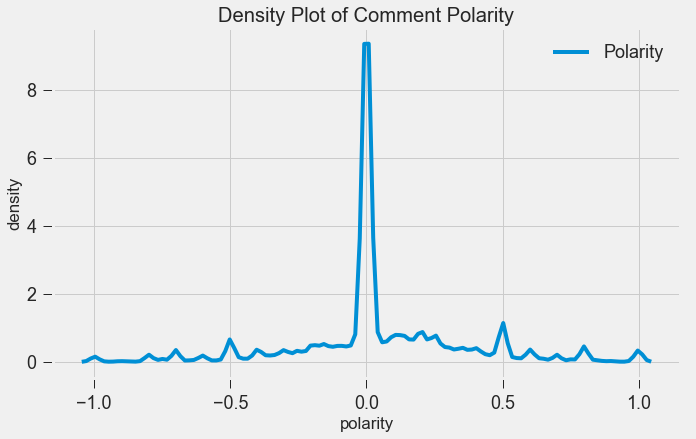

In [289]:
# https://stats.stackexchange.com/questions/5819/kernel-density-estimate-takes-values-larger-than-1

style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

sns.kdeplot(comment2topic['Polarity'])

plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Density Plot of Comment Polarity')
plt.xlabel('polarity')
plt.ylabel('density')
plt.legend(fontsize=18);
# plt.ylim((0,20))

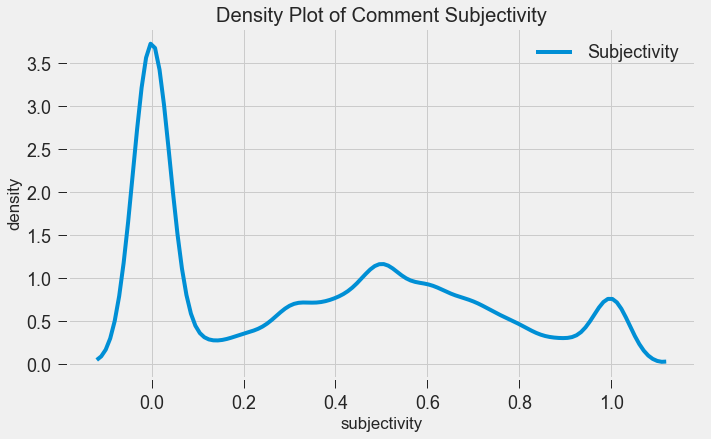

In [290]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

sns.kdeplot(comment2topic['Subjectivity'])

plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Density Plot of Comment Subjectivity')
plt.xlabel('subjectivity')
plt.ylabel('density')
plt.legend(fontsize=18);

# Sentiment Analysis with TextBlob Based on K-Means Clusters

In [384]:
comment2topic = joblib.load('comment2topic.pkl')

In [293]:
# Average polarity per cluster
avg_polarities = [comment2topic.iloc[cluster_groups[x]]['Polarity'].sum()/len(cluster_groups[x]) for x in range(17)]

In [294]:
# Average subjectivity per cluster
avg_subjectivities = [comment2topic.iloc[cluster_groups[x]]['Subjectivity'].sum()/len(cluster_groups[x]) for x in range(17)]

In [295]:
list(zip(topics,avg_polarities,avg_subjectivities))

[('Ugly', -0.5162334370940597, 0.8956667941179319),
 ('Buy', 0.04717603530691684, 0.30267709187349734),
 ('Im', 0.10255376644067574, 0.44005360393348125),
 ('??', 0.07311880901119629, 0.3259734851277829),
 ('iPhone', 0.04274073601396999, 0.2627982760190438),
 ('Apple', 0.04869460255625365, 0.3830079199188842),
 ('Samsung', 0.11909162533579566, 0.36019002886980017),
 ('f*ck', -0.32693197400070334, 0.6457611746859636),
 ('Unlock', 0.0717086440912971, 0.39084752777638004),
 ('Like', 0.08288549021035334, 0.3653645446489204),
 ('FaceID', 0.028296485713666164, 0.36907252880814434),
 ('Power Button', 0.02947556507695612, 0.3119258760439674),
 ('Looks', 0.04972116917941791, 0.450777670931863),
 ('iPhone 8 plus', 0.10316867645106292, 0.32049241595236055),
 ('HTML', 0.057454087915763515, 0.35055424397717744),
 ('iPhone X', 0.035935181721107656, 0.2709020517422843),
 ('Wireless Charger', 0.08390412901528292, 0.4245185178204705)]

In [332]:
for i in range(17):
    print('Cluster Group {}: {}. Number of comments in cluster: {}'.format(i,topics[i],len(cluster_groups[i])))

Cluster Group 0: Ugly. Number of comments in cluster: 1020
Cluster Group 1: Buy. Number of comments in cluster: 2136
Cluster Group 2: Im. Number of comments in cluster: 1957
Cluster Group 3: ??. Number of comments in cluster: 22072
Cluster Group 4: iPhone. Number of comments in cluster: 5559
Cluster Group 5: Apple. Number of comments in cluster: 3930
Cluster Group 6: Samsung. Number of comments in cluster: 2649
Cluster Group 7: f*ck. Number of comments in cluster: 1113
Cluster Group 8: Unlock. Number of comments in cluster: 4597
Cluster Group 9: Like. Number of comments in cluster: 2481
Cluster Group 10: FaceID. Number of comments in cluster: 3448
Cluster Group 11: Power Button. Number of comments in cluster: 1358
Cluster Group 12: Looks. Number of comments in cluster: 2321
Cluster Group 13: iPhone 8 plus. Number of comments in cluster: 1264
Cluster Group 14: HTML. Number of comments in cluster: 1429
Cluster Group 15: iPhone X. Number of comments in cluster: 1257
Cluster Group 16: Wire

In [442]:
topic = 0
for comment in comment2topic.iloc[cluster_groups[topic]]\
    [comment2topic.iloc[cluster_groups[topic]]['Polarity'] == comment2topic.iloc[cluster_groups[topic]]['Polarity'].max()]\
    ['Comments']:
    print(comment)
    print('\n')

There was a time where iphone7 came out it was not ugly like apple What the hell




In [346]:
unlock = comment2topic.iloc[cluster_groups[8]]

In [347]:
unlock_positive = unlock[unlock['Polarity'] > 0]
unlock_negative = unlock[unlock['Polarity'] < 0]
unlock_neutral = unlock[unlock['Polarity'] == 0]

In [366]:
len(unlock_positive)/len(unlock), len(unlock_negative)/len(unlock), len(unlock_neutral)/len(unlock)

(0.43267348270611267, 0.2410267565803785, 0.3262997607135088)

In [348]:
face = comment2topic.iloc[cluster_groups[10]]

In [349]:
face_positive = face[face['Polarity'] > 0]
face_negative = face[face['Polarity'] < 0]
face_neutral = face[face['Polarity'] == 0]

In [365]:
len(face_positive)/len(face), len(face_negative)/len(face), len(face_neutral)/len(face)

(0.40632250580046403, 0.2978538283062645, 0.29582366589327147)

In [352]:
looks = comment2topic.iloc[cluster_groups[12]]

In [353]:
looks_positive = looks[looks['Polarity'] > 0]
looks_negative = looks[looks['Polarity'] < 0]
looks_neutral = looks[looks['Polarity'] == 0]

In [364]:
len(looks_positive)/len(looks), len(looks_negative)/len(looks), len(looks_neutral)/len(looks)

(0.41706161137440756, 0.27057302886686774, 0.3123653597587247)

In [354]:
wireless = comment2topic.iloc[cluster_groups[16]]

In [355]:
wireless_positive = wireless[wireless['Polarity'] > 0]
wireless_negative = wireless[wireless['Polarity'] < 0]
wireless_neutral = wireless[wireless['Polarity'] == 0]

In [367]:
len(wireless_positive)/len(wireless), len(wireless_negative)/len(wireless), len(wireless_neutral)/len(wireless)

(0.5053272450532724, 0.2115677321156773, 0.2831050228310502)

In [448]:
comment2topic[comment2topic['Comments'].str.contains('Face ID will get better ')]

,Published at,Author,Comments,Likes,Replies,0,1,2,3,4,5,6,7,8,9,Polarity,Subjectivity
37433,2017-09-13T17:03:12.000Z,Uvan Sankar,Face ID will get better with time...Not everyt...,3,1,0.0,0.0,0.08382,0.084673,0.0,0.0,0.0,0.484738,0.303909,0.0,0.596094,0.527778


In [447]:
comment2topic.iloc[53041]['Comments']

'Impressed? Not! This wave is so not worth it anymore... I say we the people invest elsewhere until Apple comes with something noteworthy again. In my opinion Apple is so deep into themselves they don&#39;t know what to do next!!! Roman numerals now!!!'

In [433]:
for comment in unlock_negative['Comments'][220:240]:
    print(comment)
    print('\n')

&quot;no promotion display, not a big deal&quot;? i beg to differ! its a must on phones, people don&#39;t know what they are missing


My iPhone could not make texts or phone calls, have a screen smashed so badly that I had to grind my fingers down as far as my knuckles just to unlock it, come to life and kill me in my sleep and I still wouldn’t buy a Samsung..


Then how do you shut down your phone if it just going to trigger Siri?


Stupid phone


What if someone&#39;s in trouble and needs to discretely unlock their phone without raising attention. Like a spouse being attacked by their spouse, or a kidnap victim. I hope the option is there to use Touch ID in some way because a face scanner to unlock the phone is slow, dangerous for those needing police assistance, and somewhat crackable if someone took a photo of you and used that photo of you to unlock the phone. Hmph


I wonder a robber trying to steal a iPhone X by putting the phone in front of it&#39;s owner face once he took it.

# Split comments by Polarity and Count Words for Bubble Chart

https://bl.ocks.org/mbostock/4063269

## Positive

In [137]:
positive_comments = comment2topic[comment2topic['Polarity'] > 0]\
['Comments'][0:20000].str.cat(sep=' ').lower().replace('&#39;','"')

In [139]:
positive_comments = re.sub('<[^>]+>', '', positive_comments)

In [149]:
nopunc = [char for char in positive_comments if char not in string.punctuation]
nopunc = ''.join(nopunc)
positive_comments = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [160]:
len(positive_comments)

287486

In [514]:
positive_pos = nltk.pos_tag(positive_comments[:115000])
positive_nouns = [word[0] for word in positive_pos if word[1] == 'NN' or word[1] == 'NNS']
positive_adj = [word[0] for word in positive_pos if word[1] == 'JJ' or word[1] == 'JJS']

In [515]:
positive_words = Counter(positive_comments).most_common()
positive_nouns = Counter(positive_nouns).most_common()
positive_adj = Counter(positive_adj).most_common()

## Negative

In [157]:
negative_comments = comment2topic[comment2topic['Polarity'] < 0]\
['Comments'][0:20000].str.cat(sep=' ').lower().replace('&#39;','"')

In [158]:
negative_comments = re.sub('<[^>]+>', '', negative_comments)

In [159]:
nopunc = [char for char in negative_comments if char not in string.punctuation]
nopunc = ''.join(nopunc)
negative_comments = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [161]:
len(negative_comments)

157887

In [516]:
negative_pos = nltk.pos_tag(negative_comments[:115000])
negative_nouns = [word[0] for word in negative_pos if word[1] == 'NN' or word[1] == 'NNS']
negative_adj = [word[0] for word in negative_pos if word[1] == 'JJ' or word[1] == 'JJS']

In [517]:
negative_words = Counter(negative_comments).most_common()
negative_nouns = Counter(negative_nouns).most_common()
negative_adj = Counter(negative_adj).most_common()

## Neutral

In [164]:
neutral_comments = comment2topic[comment2topic['Polarity'] == 0]\
['Comments'][0:20000].str.cat(sep=' ').lower().replace('&#39;','"')

In [166]:
neutral_comments = re.sub('<[^>]+>', '', neutral_comments)

In [167]:
nopunc = [char for char in neutral_comments if char not in string.punctuation]
nopunc = ''.join(nopunc)
neutral_comments = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [168]:
len(neutral_comments)

115922

In [518]:
neutral_pos = nltk.pos_tag(neutral_comments[:115000])
neutral_nouns = [word[0] for word in neutral_pos if word[1] == 'NN' or word[1] == 'NNS']
neutral_adj = [word[0] for word in neutral_pos if word[1] == 'JJ' or word[1] == 'JJS']

In [519]:
neutral_words = Counter(neutral_comments).most_common()
neutral_nouns = Counter(neutral_nouns).most_common()
neutral_adj = Counter(neutral_adj).most_common()

## Nouns

In [526]:
positive_nouns[:20]

[('iphone', 3338),
 ('apple', 1854),
 ('phone', 1704),
 ('samsung', 554),
 ('im', 546),
 ('x', 479),
 ('people', 431),
 ('phones', 418),
 ('face', 409),
 ('video', 405),
 ('screen', 401),
 ('lol', 365),
 ('price', 355),
 ('dont', 355),
 ('camera', 350),
 ('years', 313),
 ('year', 303),
 ('id', 300),
 ('thing', 296),
 ('s8', 292)]

In [527]:
negative_nouns[:20]

[('iphone', 2834),
 ('phone', 2157),
 ('apple', 2132),
 ('face', 1431),
 ('id', 973),
 ('people', 547),
 ('samsung', 444),
 ('im', 422),
 ('time', 417),
 ('x', 391),
 ('dont', 374),
 ('screen', 366),
 ('phones', 341),
 ('shit', 315),
 ('camera', 308),
 ('thats', 294),
 ('way', 293),
 ('button', 288),
 ('thing', 286),
 ('unlock', 284)]

In [528]:
neutral_nouns[:20]

[('iphone', 4814),
 ('apple', 1863),
 ('phone', 1762),
 ('face', 1223),
 ('pwm', 962),
 ('id', 797),
 ('samsung', 698),
 ('x', 620),
 ('ho', 619),
 ('im', 483),
 ('dont', 455),
 ('button', 405),
 ('s8', 334),
 ('unlock', 329),
 ('video', 319),
 ('plz', 316),
 ('jack', 277),
 ('people', 272),
 ('buy', 270),
 ('screen', 269)]

## Adjectives

In [529]:
positive_adj[:20]

[('new', 1010),
 ('good', 633),
 ('iphone', 487),
 ('much', 424),
 ('great', 340),
 ('x', 306),
 ('best', 302),
 ('nice', 284),
 ('real', 264),
 ('android', 237),
 ('many', 228),
 ('top', 210),
 ('old', 206),
 ('screen', 197),
 ('im', 196),
 ('lol', 183),
 ('u', 178),
 ('next', 174),
 ('full', 173),
 ('dont', 165)]

In [530]:
negative_adj[:20]

[('iphone', 469),
 ('touch', 426),
 ('new', 391),
 ('bad', 371),
 ('stupid', 368),
 ('black', 291),
 ('shit', 277),
 ('id', 273),
 ('wrong', 270),
 ('expensive', 251),
 ('fuck', 242),
 ('u', 239),
 ('x', 223),
 ('enable', 218),
 ('screen', 210),
 ('unlock', 202),
 ('android', 196),
 ('dont', 191),
 ('im', 187),
 ('fake', 174)]

In [531]:
neutral_adj[:20]

[('iphone', 712),
 ('u', 435),
 ('touch', 392),
 ('x', 354),
 ('android', 232),
 ('samsung', 226),
 ('id', 217),
 ('cant', 200),
 ('unlock', 196),
 ('enable', 193),
 ('next', 189),
 ('screen', 166),
 ('dont', 153),
 ('s8', 151),
 ('im', 150),
 ('big', 127),
 ('facial', 101),
 ('ur', 99),
 ('xpensive', 96),
 ('galaxy', 87)]

# Vader Sentiment Analysis

In [637]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [656]:
analyzer = SentimentIntensityAnalyzer()

In [657]:
def vadersentiment(comment):
    '''
    Return compound score.
    '''
    vs = analyzer.polarity_scores(comment)
    return vs['compound']

In [658]:
comment2topic = joblib.load('comment2topic.pkl')

In [659]:
comment2topic['Compound'] = comment2topic['Comments'].apply(vadersentiment)

In [662]:
comment2topic['Sentiment Difference'] = comment2topic['Polarity']*comment2topic['Compound']

In [224]:
# comment2topic[(comment2topic['Sentiment Difference'] < 0)]

In [223]:
# comment2topic[comment2topic['Compound'] == comment2topic['Compound'].min()]

In [842]:
comment2topic.iloc[78]['Comments']

'The fundamental problem for Apple is that anything beyond the 6 for most users (by performance specs etc) isn&#39;t really needed, the latest iPhone models are basically superfluous. If someone watching this video is still unsure, stick with/or go for the iPhone 6. It&#39;s cheaper, has all the same &#39;important&#39; features such as NFS for your bank cards, and will perform well enough (even photo/video) to a point you simply wouldn&#39;t notice unless you&#39;re a tech geek. Unless you&#39;re trying to be the edgiest dude editing 4k video on a device that just isn&#39;t convenient for purpose, but simply a marketing ploy, a gimmick.'

In [677]:
for comment in comment2topic[(comment2topic['Sentiment Difference'] < 0) & (comment2topic['Compound'] > 0)]['Comments'][:20]:
    print(comment)
    print('\n')

I have had the 6plus for three years now without updating it in the past 1.5 years. I haven&#39;t had any problems up until the past month where it freezes daily and I have to do hard resets and its also logs me out of every app and account I have on my phone sporadically. I can&#39;t imagine dishing out $1000 on a prototype phone like the iPhone X. However, can anyone advise me on upgrading to the iPhone 8 plus? Is it worth it?


Face recognition sounds like a PITA to me, I would have to take off my sunglasses or safety googles every time I wanted to use the phone. No thanks!


all my banking and credit card apps use touch id, i doubt they will support face recognition. for this reason alone im leaning heavily toward the 8.


Hope people know a iPhone 10 is like a 6 7 8 screen size the screen isn’t bigger than a plus. You will waste your money on the 10 and will be out of luck when the 10 Plus come out.


As soon as iphone 8 and X got out My Iphone 5 S is fucking up now its like going

In [843]:
unlock = comment2topic.iloc[cluster_groups[8]]

In [844]:
unlock_positive = unlock[unlock['Compound'] > 0]
unlock_negative = unlock[unlock['Compound'] < 0]
unlock_neutral = unlock[unlock['Compound'] == 0]

In [845]:
len(unlock_positive)/len(unlock), len(unlock_negative)/len(unlock), len(unlock_neutral)/len(unlock)

(0.370023928649119, 0.30280617794213616, 0.32716989340874486)

In [846]:
face = comment2topic.iloc[cluster_groups[10]]

In [847]:
face_positive = face[face['Compound'] > 0]
face_negative = face[face['Compound'] < 0]
face_neutral = face[face['Compound'] == 0]

In [848]:
len(face_positive)/len(face), len(face_negative)/len(face), len(face_neutral)/len(face)

(0.36513921113689096, 0.37412993039443154, 0.2607308584686775)

In [849]:
looks = comment2topic.iloc[cluster_groups[12]]

In [850]:
looks_positive = looks[looks['Compound'] > 0]
looks_negative = looks[looks['Compound'] < 0]
looks_neutral = looks[looks['Compound'] == 0]

In [851]:
len(looks_positive)/len(looks), len(looks_negative)/len(looks), len(looks_neutral)/len(looks)

(0.6174062903920724, 0.26928048255062476, 0.11331322705730289)

In [852]:
wireless = comment2topic.iloc[cluster_groups[16]]

In [853]:
wireless_positive = wireless[wireless['Compound'] > 0]
wireless_negative = wireless[wireless['Compound'] < 0]
wireless_neutral = wireless[wireless['Compound'] == 0]

In [854]:
len(wireless_positive)/len(wireless), len(wireless_negative)/len(wireless), len(wireless_neutral)/len(wireless)

(0.410958904109589, 0.2633181126331811, 0.3257229832572298)

In [871]:
comment2topic[comment2topic['Comments'].str.contains('I bet the wireless charger is half the price of the phone itself.')]

,Published at,Author,Comments,Likes,Replies,0,1,2,3,4,5,6,7,8,9,Polarity,Subjectivity,Compound,Sentiment Difference
52652,2017-09-15T14:30:14.000Z,xD,I bet the wireless charger is half the price o...,167,5,0.0,0.175877,0.0,0.0,0.0,0.0,0.0,0.280047,0.0,0.485739,-0.166667,0.166667,0.0,-0.0


In [447]:
comment2topic.iloc[53041]['Comments']

'Impressed? Not! This wave is so not worth it anymore... I say we the people invest elsewhere until Apple comes with something noteworthy again. In my opinion Apple is so deep into themselves they don&#39;t know what to do next!!! Roman numerals now!!!'

In [864]:
for comment in face_negative['Comments'][120:140]:
    print(comment)
    print('\n')

Crapple phone is 💩, they can take face ID and that god awful notch at the top and shove it up their ass!!!


Will face regn works in extreme low light


What if I have a twin? , now what can you do face I&#39;d ,I am fucked !


Used to be if I wanted to steal your iPhone I would cut off your fingers so I could use touch ID. Now I have to cut off your goddamn head.


Face id is fucking stupid


So apple is building a database with the touch ID and now the face scanner ! This scares me a little


Why no touch ID in the apple logo? :&#39;)


Its a complete crap phone.<br />They couldnt make a invisible fingerprint scanner, so they made the &#39;face id&#39;.<br />The face id that failed horrible on the launch event.


It looks horrible and the notch is just ugly. I will keep my home button it&#39;s been causing problems in Touch ID in all the beta software once you start having issues with Touch ID even reverting really does not fix the problem


I hate the face id. Sometimes the phone is

# Supervised Learning by Predicting Likes and Replies

In [801]:
comment2topic = joblib.load('comment2topic.pkl')

In [802]:
def make_log(x):
    return np.log(x)

In [761]:
X = comment2topic[[0,1,2,3,4,5,6,7,8,9,'Polarity','Subjectivity']]
y = comment2topic['Likes'].apply(make_log)

In [762]:
from numpy import inf
y[y == -inf] = 0

In [763]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Multiple Linear Regression

In [764]:
lr_model1 = LinearRegression()
lr_model1.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [765]:
list(zip(X_train.columns,lr_model1.coef_))

[(0, -0.71342219109371585),
 (1, -0.60360554105818753),
 (2, -0.68072140046244767),
 (3, -0.75075654412696258),
 (4, -0.65994378952755606),
 (5, -0.60757763485272187),
 (6, -0.8141618037297379),
 (7, -0.64905582560430886),
 (8, -0.76337786345513114),
 (9, -0.77543855947110019),
 ('Polarity', -0.0089931125884864516),
 ('Subjectivity', 0.014120964507056605)]

In [766]:
lr_test_pred1 = lr_model1.predict(X_test)

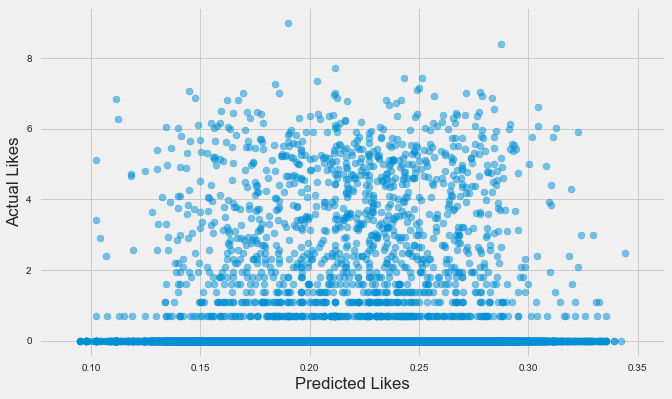

In [767]:
## Plot predicted vs actual 
style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

plt.scatter(lr_test_pred1,y_test,alpha=0.5,)
# plt.plot(np.linspace(-8,2,1000),np.linspace(-8,2,1000))
plt.xlabel('Predicted Likes')
plt.ylabel('Actual Likes')

## Logistic Regression

In [144]:
comment2topic = joblib.load('comment2topic.pkl')

In [145]:
X = comment2topic[[0,1,2,3,4,5,6,7,8,9,'Polarity','Subjectivity']]
y = comment2topic['Likes']

In [146]:
def make_binary(x):
    if x>0:
        return 1
    else:
        return 0

In [147]:
y = y.apply(make_binary)

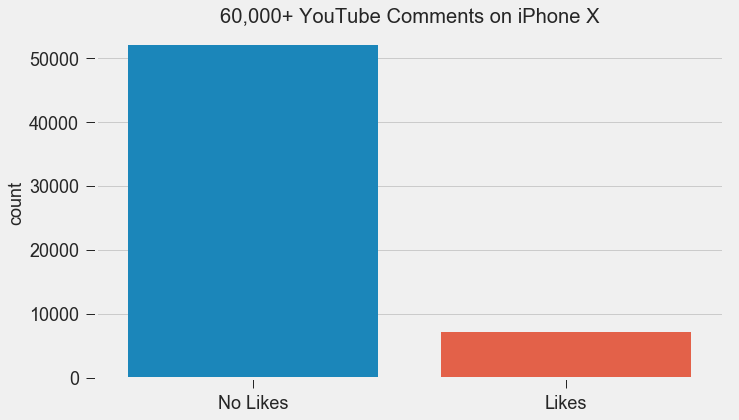

In [222]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

sns.countplot(y)

plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('60,000+ YouTube Comments on iPhone X')
plt.xlabel('')
plt.ylabel('count', fontsize=18)
plt.xticks(np.arange(2),('No Likes','Likes'));

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [150]:
log = LogisticRegression()
log.fit(X_train,y_train)
log_pred = log.predict(X_test)

print(log)
print('Accuracy: ',accuracy_score(y_test,log_pred))
print('Precision: ',precision_score(y_test,log_pred))
print('Recall: ',recall_score(y_test,log_pred))
print('f1: ',f1_score(y_test,log_pred,))
print('Confusion Matrix: \n',confusion_matrix(y_test,log_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy:  0.88135021097
Precision:  0.0
Recall:  0.0
f1:  0.0
Confusion Matrix: 
 [[15666     0]
 [ 2109     0]]


/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Finding the best k-value for KNN

In [81]:
error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

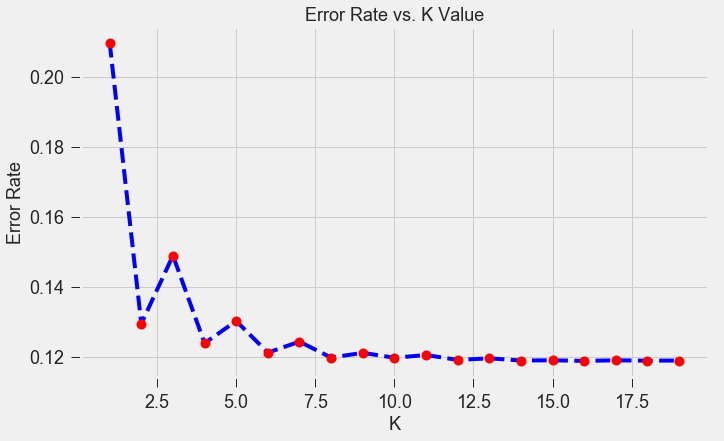

In [82]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value',fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.xlabel('K',fontsize=18)
plt.ylabel('Error Rate',fontsize=18);

In [151]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)

print(knn)
print('Accuracy: ',accuracy_score(y_test,knn_pred))
print('Precision: ',precision_score(y_test,knn_pred))
print('Recall: ',recall_score(y_test,knn_pred))
print('f1: ',f1_score(y_test,knn_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,knn_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')
Accuracy:  0.880506329114
Precision:  0.2
Recall:  0.00237079184448
f1:  0.00468603561387
Confusion Matrix: 
 [[15646    20]
 [ 2104     5]]


## Decision Tree model

In [152]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_test)

print(dtree)
print('Accuracy: ',accuracy_score(y_test,dtree_pred))
print('Precision: ',precision_score(y_test,dtree_pred))
print('Recall: ',recall_score(y_test,dtree_pred))
print('f1: ',f1_score(y_test,dtree_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,dtree_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy:  0.793248945148
Precision:  0.127497621313
Recall:  0.127074442864
f1:  0.127285680361
Confusion Matrix: 
 [[13832  1834]
 [ 1841   268]]


In [153]:
list(zip(X_train.columns, dtree.feature_importances_))

[(0, 0.087756025213104188),
 (1, 0.092076097153075326),
 (2, 0.076088923735148459),
 (3, 0.076373319110272744),
 (4, 0.10908693001694551),
 (5, 0.078247070619636941),
 (6, 0.063453397605443357),
 (7, 0.10863463683235625),
 (8, 0.085768970636749292),
 (9, 0.07390012607691307),
 ('Polarity', 0.077097744630574852),
 ('Subjectivity', 0.071516758369779956)]

## Thresholding with Decision Tree

In [157]:
dtree_thresh = dtree.predict_proba(X_test)

In [158]:
dtree_thresh_pred = []
for point in dtree_thresh:
    if point[0] == 1:
        dtree_thresh_pred.append(0)
    else:
        dtree_thresh_pred.append(1)

In [159]:
print(dtree)
print('Accuracy: ',accuracy_score(y_test,dtree_thresh_pred))
print('Precision: ',precision_score(y_test,dtree_thresh_pred))
print('Recall: ',recall_score(y_test,dtree_thresh_pred))
print('f1: ',f1_score(y_test,dtree_thresh_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,dtree_thresh_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy:  0.729957805907
Precision:  0.120665351001
Recall:  0.202939781887
f1:  0.151343705799
Confusion Matrix: 
 [[12547  3119]
 [ 1681   428]]


In [160]:
Counter(y_test)

Counter({0: 15666, 1: 2109})

## SMOTE with Decision Tree

In [161]:
from imblearn.over_sampling import SMOTE

In [162]:
sm = SMOTE()
X_res, y_res = sm.fit_sample(X_train, y_train)

In [163]:
dtree_smote = DecisionTreeClassifier()
dtree_smote.fit(X_res,y_res)
dtree_smote_pred = dtree_smote.predict(X_test)

print(dtree)
print('Accuracy: ',accuracy_score(y_test,dtree_smote_pred))
print('Precision: ',precision_score(y_test,dtree_smote_pred))
print('Recall: ',recall_score(y_test,dtree_smote_pred))
print('f1: ',f1_score(y_test,dtree_smote_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,dtree_smote_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy:  0.737665260197
Precision:  0.125513196481
Recall:  0.202939781887
f1:  0.155100561696
Confusion Matrix: 
 [[12684  2982]
 [ 1681   428]]


## SMOTE and Thresholding with Decision Tree

In [165]:
dtree_smote_thresh = dtree_smote.predict_proba(X_test)

In [166]:
dtree_smote_thresh_pred = []
for point in dtree_smote_thresh:
    if point[0] == 1:
        dtree_smote_thresh_pred.append(0)
    else:
        dtree_smote_thresh_pred.append(1)

In [167]:
print(dtree_smote)
print('Accuracy: ',accuracy_score(y_test,dtree_smote_thresh_pred))
print('Precision: ',precision_score(y_test,dtree_smote_thresh_pred))
print('Recall: ',recall_score(y_test,dtree_smote_thresh_pred))
print('f1: ',f1_score(y_test,dtree_smote_thresh_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,dtree_smote_thresh_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy:  0.698284106892
Precision:  0.119682094437
Recall:  0.242769084874
f1:  0.1603256615
Confusion Matrix: 
 [[11900  3766]
 [ 1597   512]]


In [168]:
list(zip(X_train.columns, dtree_smote.feature_importances_))

[(0, 0.053081295806658137),
 (1, 0.055765984745657561),
 (2, 0.11891318651113435),
 (3, 0.061419307826682763),
 (4, 0.077279350011280612),
 (5, 0.29887243830892019),
 (6, 0.061567841227783804),
 (7, 0.067135737691711148),
 (8, 0.056607153605099332),
 (9, 0.047267063491332445),
 ('Polarity', 0.049991065276807745),
 ('Subjectivity', 0.052099575496931894)]

## Random Forest Classifier model

In [169]:
randf = RandomForestClassifier(max_features=3,min_samples_leaf=3,n_estimators=600)
randf.fit(X_train,y_train)
randf_pred = randf.predict(X_test)

print(randf)
print('Accuracy: ',accuracy_score(y_test,randf_pred))
print('Precision: ',precision_score(y_test,randf_pred))
print('Recall: ',recall_score(y_test,randf_pred))
print('f1: ',f1_score(y_test,randf_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,randf_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.88123769339
Precision:  0.4375
Recall:  0.00331910858227
f1:  0.00658823529412
Confusion Matrix: 
 [[15657     9]
 [ 2102     7]]


In [170]:
list(zip(X_train.columns, randf.feature_importances_))

[(0, 0.084018185807074069),
 (1, 0.085798087750820956),
 (2, 0.080572786048624889),
 (3, 0.079243735334755414),
 (4, 0.10639104394988613),
 (5, 0.07518684964383103),
 (6, 0.065200987671079347),
 (7, 0.10600893563951888),
 (8, 0.086328173043485321),
 (9, 0.078474189733339875),
 ('Polarity', 0.07858536031714243),
 ('Subjectivity', 0.074191665060441725)]

## Thresholding with Random Forest

In [171]:
randf_thresh = randf.predict_proba(X_test)

In [172]:
randf_thresh_pred = []
for point in randf_thresh:
    if point[0] < 0.9:
        randf_thresh_pred.append(0)
    else:
        randf_thresh_pred.append(1)

In [173]:
print(randf)
print('Accuracy: ',accuracy_score(y_test,randf_thresh_pred))
print('Precision: ',precision_score(y_test,randf_thresh_pred))
print('Recall: ',recall_score(y_test,randf_thresh_pred))
print('f1: ',f1_score(y_test,randf_thresh_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,randf_thresh_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.59870604782
Precision:  0.118237082067
Recall:  0.368895211
f1:  0.1790769939
Confusion Matrix: 
 [[9864 5802]
 [1331  778]]


## SMOTE with Random Forest

In [174]:
sm = SMOTE()
X_res, y_res = sm.fit_sample(X_train, y_train)

In [175]:
randf_smote = RandomForestClassifier()
randf_smote.fit(X_res,y_res)
randf_smote_pred = randf_smote.predict(X_test)

print(randf)
print('Accuracy: ',accuracy_score(y_test,randf_smote_pred))
print('Precision: ',precision_score(y_test,randf_smote_pred))
print('Recall: ',recall_score(y_test,randf_smote_pred))
print('f1: ',f1_score(y_test,randf_smote_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,randf_smote_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.817271448664
Precision:  0.143839899937
Recall:  0.109056424846
f1:  0.12405609493
Confusion Matrix: 
 [[14297  1369]
 [ 1879   230]]


## SMOTE and Thresholding with Random Forest

In [176]:
randf_smote_thresh = randf_smote.predict_proba(X_test)

In [177]:
randf_smote_thresh_pred = []
for point in randf_smote_thresh:
    if point[0] < 0.9:
        randf_smote_thresh_pred.append(0)
    else:
        randf_smote_thresh_pred.append(1)

In [178]:
print(randf_smote)
print('Accuracy: ',accuracy_score(y_test,randf_smote_thresh_pred))
print('Precision: ',precision_score(y_test,randf_smote_thresh_pred))
print('Recall: ',recall_score(y_test,randf_smote_thresh_pred))
print('f1: ',f1_score(y_test,randf_smote_thresh_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,randf_smote_thresh_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.527032348805
Precision:  0.121514423077
Recall:  0.479374110953
f1:  0.193882443187
Confusion Matrix: 
 [[8357 7309]
 [1098 1011]]


## Random Over Sampler with Random Forest

In [179]:
from imblearn.over_sampling import RandomOverSampler

In [180]:
ros = RandomOverSampler()

In [181]:
X_res, y_res = ros.fit_sample(X_train, y_train)

In [182]:
randf_ros = RandomForestClassifier()
randf_ros.fit(X_res,y_res)
randf_ros_pred = randf_ros.predict(X_test)

print(randf)
print('Accuracy: ',accuracy_score(y_test,randf_ros_pred))
print('Precision: ',precision_score(y_test,randf_ros_pred))
print('Recall: ',recall_score(y_test,randf_ros_pred))
print('f1: ',f1_score(y_test,randf_ros_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,randf_ros_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.830154711674
Precision:  0.138888888889
Recall:  0.0829777145567
f1:  0.103888394182
Confusion Matrix: 
 [[14581  1085]
 [ 1934   175]]


## Gradient Boosting Classifier model

In [183]:
gboost = GradientBoostingClassifier(learning_rate=0.1,max_depth=1,subsample=0.5,n_estimators=500)
gboost.fit(X_train,y_train)
gboost_pred = gboost.predict(X_test)

print(gboost)
print('Accuracy: ',accuracy_score(y_test,gboost_pred))
print('Precision: ',precision_score(y_test,gboost_pred))
print('Recall: ',recall_score(y_test,gboost_pred))
print('f1: ',f1_score(y_test,gboost_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,gboost_pred))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
Accuracy:  0.88135021097
Precision:  0.0
Recall:  0.0
f1:  0.0
Confusion Matrix: 
 [[15666     0]
 [ 2109     0]]


/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [184]:
list(zip(X_train.columns, gboost.feature_importances_))

[(0, 0.064000000000000001),
 (1, 0.089999999999999997),
 (2, 0.13800000000000001),
 (3, 0.075999999999999998),
 (4, 0.091999999999999998),
 (5, 0.22800000000000001),
 (6, 0.040000000000000001),
 (7, 0.087999999999999995),
 (8, 0.070000000000000007),
 (9, 0.035999999999999997),
 ('Polarity', 0.037999999999999999),
 ('Subjectivity', 0.040000000000000001)]

## XGBoost

In [185]:
import xgboost as xgb

In [186]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=600, learning_rate=0.05, objective='count:poisson')

In [187]:
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)

In [188]:
print(gbm)
print('Accuracy: ',accuracy_score(y_test,gbm_pred))
print('Precision: ',precision_score(y_test,gbm_pred))
print('Recall: ',recall_score(y_test,gbm_pred))
print('f1: ',f1_score(y_test,gbm_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,gbm_pred))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='count:poisson', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuracy:  0.880900140647
Precision:  0.166666666667
Recall:  0.00094831673779
f1:  0.001885902876
Confusion Matrix: 
 [[15656    10]
 [ 2107     2]]


## Thresholding with XGBoost

In [189]:
gbm_thresh = gbm.predict_proba(X_test)

In [190]:
gbm_thresh_pred = []
for point in gbm_thresh:
    if point[0] < 0.9:
        gbm_thresh_pred.append(0)
    else:
        gbm_thresh_pred.append(1)

In [191]:
print(gbm)
print('Accuracy: ',accuracy_score(y_test,gbm_thresh_pred))
print('Precision: ',precision_score(y_test,gbm_thresh_pred))
print('Recall: ',recall_score(y_test,gbm_thresh_pred))
print('f1: ',f1_score(y_test,gbm_thresh_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,gbm_thresh_pred))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='count:poisson', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuracy:  0.629479606188
Precision:  0.114649681529
Recall:  0.315789473684
f1:  0.168224299065
Confusion Matrix: 
 [[10523  5143]
 [ 1443   666]]


## SMOTE with XGBoost

In [192]:
sm = SMOTE()
X_res, y_res = sm.fit_sample(X_train, y_train)

In [193]:
gbm_smote = xgb.XGBClassifier(max_depth=5, n_estimators=600, learning_rate=0.05, objective='count:poisson')
gbm_smote.fit(X_res,y_res)
gbm_smote_pred = gbm_smote.predict(X_test.values)

print(gbm_smote)
print('Accuracy: ',accuracy_score(y_test,gbm_smote_pred))
print('Precision: ',precision_score(y_test,gbm_smote_pred))
print('Recall: ',recall_score(y_test,gbm_smote_pred))
print('f1: ',f1_score(y_test,gbm_smote_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,gbm_smote_pred))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='count:poisson', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuracy:  0.815302390999
Precision:  0.134495641345
Recall:  0.102418207681
f1:  0.116285329744
Confusion Matrix: 
 [[14276  1390]
 [ 1893   216]]


## SMOTE and Thresholding with XGBoost

In [194]:
gbm_smote_thresh = gbm_smote.predict_proba(X_test.values)

In [195]:
gbm_smote_thresh_pred = []
for point in gbm_smote_thresh:
    if point[0] < 0.8:
        gbm_smote_thresh_pred.append(0)
    else:
        gbm_smote_thresh_pred.append(1)

In [196]:
print(gbm_smote)
print('Accuracy: ',accuracy_score(y_test,gbm_smote_thresh_pred))
print('Precision: ',precision_score(y_test,gbm_smote_thresh_pred))
print('Recall: ',recall_score(y_test,gbm_smote_thresh_pred))
print('f1: ',f1_score(y_test,gbm_smote_thresh_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,gbm_smote_thresh_pred))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='count:poisson', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuracy:  0.614120956399
Precision:  0.121091257179
Recall:  0.359886201991
f1:  0.181210457204
Confusion Matrix: 
 [[10157  5509]
 [ 1350   759]]


# Results

In [211]:
accuracy_scores = [accuracy_score(y_test,randf_smote_thresh_pred),accuracy_score(y_test,gbm_smote_thresh_pred),
                   accuracy_score(y_test,randf_thresh_pred),accuracy_score(y_test,dtree_smote_thresh_pred)]
precision_scores = [precision_score(y_test,randf_smote_thresh_pred),precision_score(y_test,gbm_smote_thresh_pred),
                    precision_score(y_test,randf_thresh_pred),precision_score(y_test,dtree_smote_thresh_pred)]
recall_scores = [recall_score(y_test,randf_smote_thresh_pred),recall_score(y_test,gbm_smote_thresh_pred),
                 recall_score(y_test,randf_thresh_pred),recall_score(y_test,dtree_smote_thresh_pred)]
f1_scores = [f1_score(y_test,randf_smote_thresh_pred),f1_score(y_test,gbm_smote_thresh_pred),
             f1_score(y_test,randf_thresh_pred),f1_score(y_test,dtree_smote_thresh_pred)]

In [212]:
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], [240/255,228/255,66/255],
          [213/255,94/255,0], [0,114/255,178/255],[204/255,121/255,167/255],[128/255,0,0],
          [128/255,128/255,0], [0,128/255,0],[128/255,0,128/255],[0,0,128/255]]

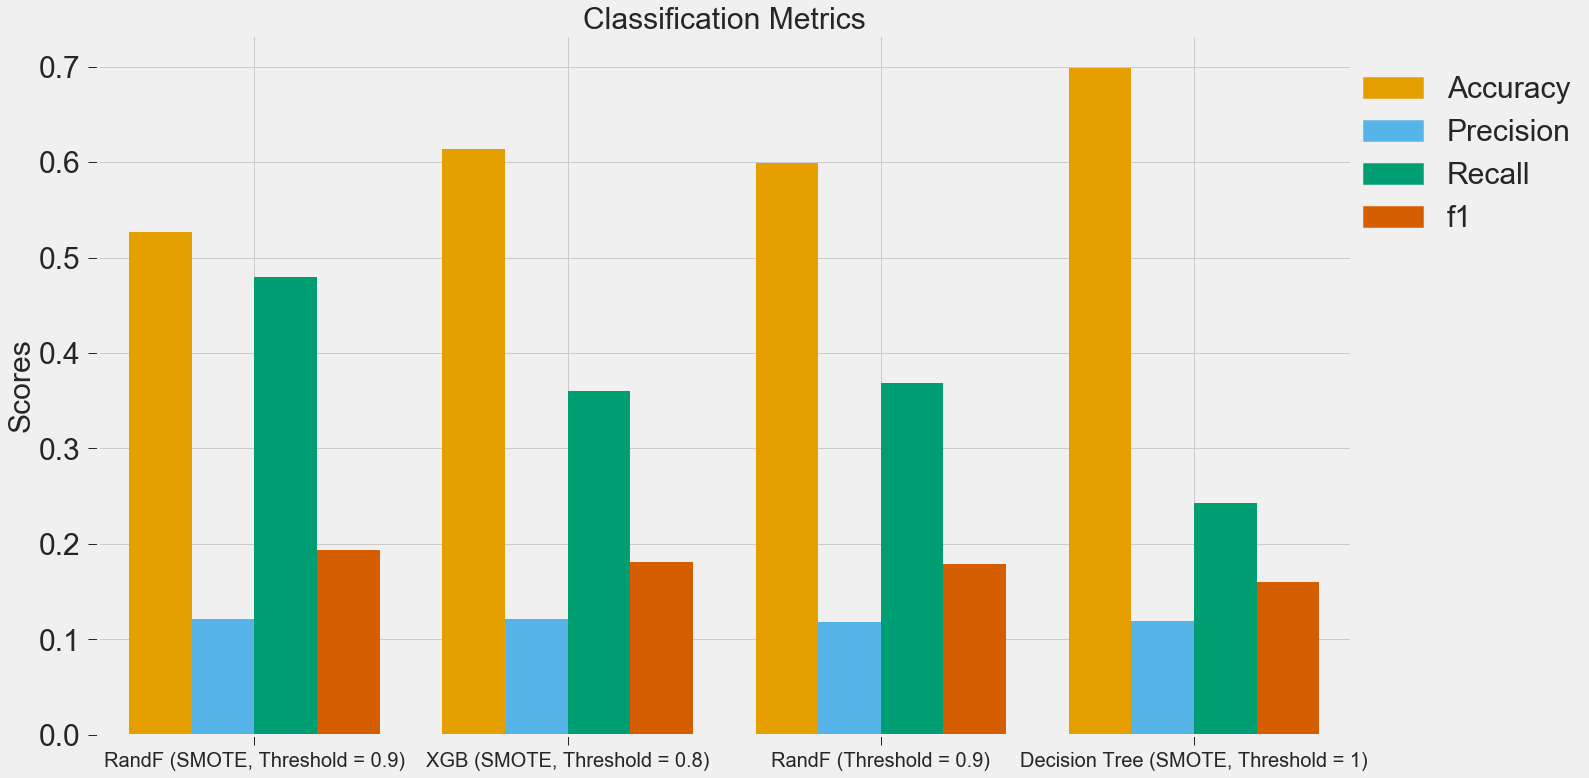

In [219]:
style.use('fivethirtyeight')

pos = list(range(4)) 
width = 0.20 

fig, ax = plt.subplots(figsize=(20,12))

blue_patch = mpatches.Patch(color=colors[1], label='Accuracy')
red_patch = mpatches.Patch(color=colors[2], label='Precision')
green_patch = mpatches.Patch(color=colors[3], label='Recall')
yellow_patch = mpatches.Patch(color=colors[5], label='f1')

plt.legend(handles=[blue_patch,red_patch,green_patch,yellow_patch,],prop={'size': 30},loc=(1,0.7))

plt.bar(pos, accuracy_scores, width, color=colors[1], label='Accuracy Score')
plt.bar([p + width for p in pos], precision_scores, width, color=colors[2], label='Precision Score') 
plt.bar([p + width*2 for p in pos], recall_scores, width, color=colors[3], label='Recall Score')
plt.bar([p + width*3 for p in pos], f1_scores, width, color=colors[5], label='f1 Score')

ax.set_ylabel('Scores',fontsize=30)
ax.set_title('Classification Metrics',fontsize=30)
ax.set_xticks([p + 1.5 * width for p in pos])
plt.tick_params(axis='both',size=10, labelsize=30)
plt.xlim(min(pos)-width, max(pos)+width*4)
ax.set_xticklabels(['RandF (SMOTE, Threshold = 0.9)','XGB (SMOTE, Threshold = 0.8)',
                    'RandF (Threshold = 0.9)','Decision Tree (SMOTE, Threshold = 1)'],fontsize=20);